In [101]:
import numpy as np
import pandas as pd
import scanpy as sc
import anndata as an
import sklearn.metrics
from matplotlib import pyplot as plt
import seaborn as sns

In [102]:
#adata=sc.read(results_file_post)
#adata.uns['log1p'] = {"base":None}

Set up out properties

In [103]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.9.3 anndata==0.9.1 umap==0.5.3 numpy==1.21.5 scipy==1.7.3 pandas==1.5.3 scikit-learn==1.0.2 statsmodels==0.13.5 python-igraph==0.10.4 pynndescent==0.5.10


In [104]:
#%matplotlib inline

Set scanpy out-files

In [105]:
writeDir = "write/"

fileName = "LUADpdx"

resultsFileQC = writeDir + fileName + '_QC.h5ad' 


Set figure parameters

In [106]:
sc.set_figure_params(scanpy=True, dpi=100, dpi_save=150, fontsize=10, format='png')
sc.settings.figdir = "figures/" + fileName + "/"
figName = fileName

read input file

In [107]:
inDir = 'data/LUAD/'
#inputFile = f'{inDir}/.txt'
#inMetaFile = f'{inDir}/.txt'

In [108]:
pdxName1 = "PDX_LX369_LX29_Ru699_LX278"
pdxName2 ="PDX_LX55A_29A_369"
pdxName3 ="PDX_Ru465_210_318"
pdxName4 ="PDX-JHU55A_Ru699_Ru890"
adatas=[]

In [109]:
pdxFile = f"{inDir}{pdxName1}_filtered_feature_bc_matrix.h5"

In [110]:
adata = sc.read_10x_h5(pdxFile, gex_only=False)
adata

reading data/LUAD/PDX_LX369_LX29_Ru699_LX278_filtered_feature_bc_matrix.h5
 (0:00:01)


/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 13836 × 68892
    var: 'gene_ids', 'feature_types', 'genome'

In [111]:
numHash = adata.var["feature_types"].value_counts()["Antibody Capture"]

In [112]:
hto = adata[:,-numHash:]
adata = adata[:,:-numHash]

In [113]:
hashes = list(hto.var.index)

In [114]:
hashdf = pd.DataFrame(hto.X.todense(), index=adata.obs_names ,columns=hashes)

In [115]:
adata.obs = adata.obs.join(hashdf)

/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [116]:
adata.var_names_make_unique()
adata.obs_names_make_unique()

normalizing counts per cell
    finished (0:00:00)


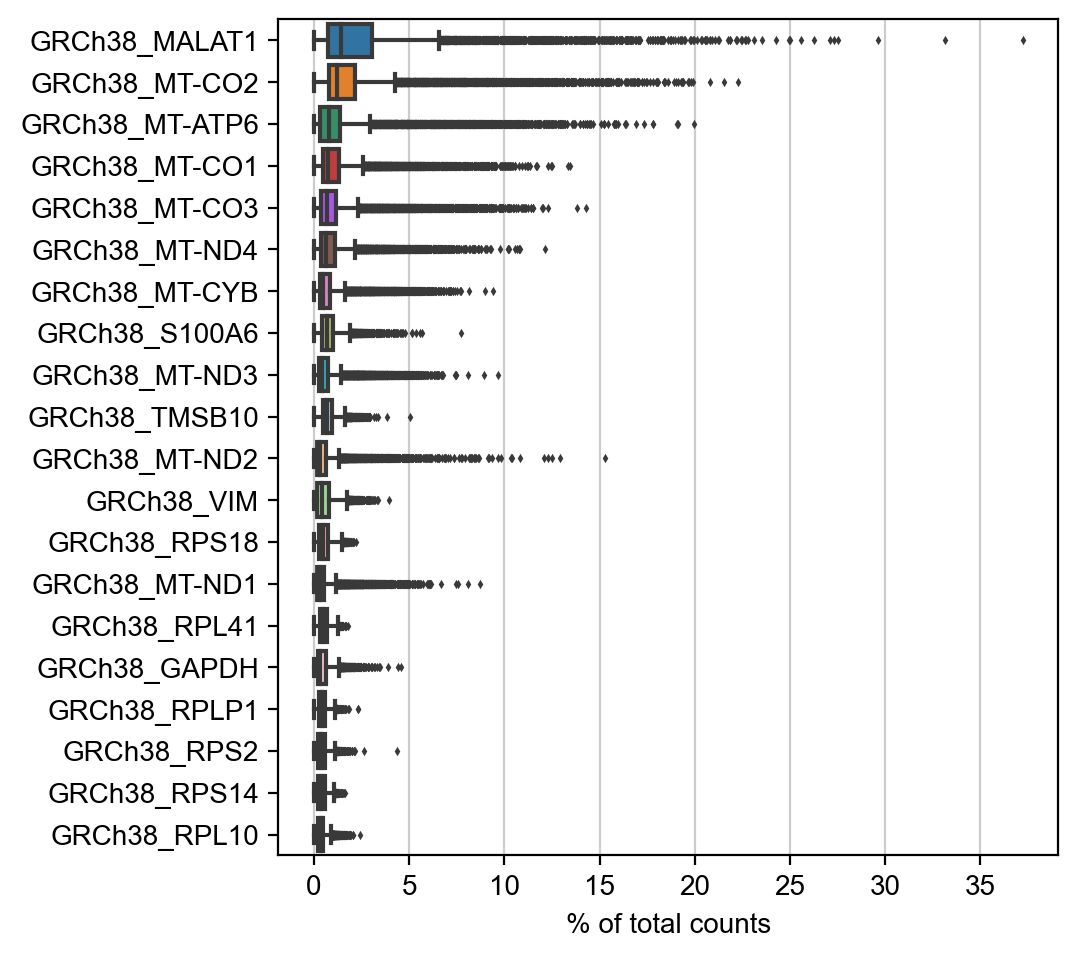

In [117]:
sc.pl.highest_expr_genes(adata, n_top=20, )

/var/folders/nc/t9t85q_94q7g4tf0gz83qts40000gn/T/ipykernel_15760/4199059595.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


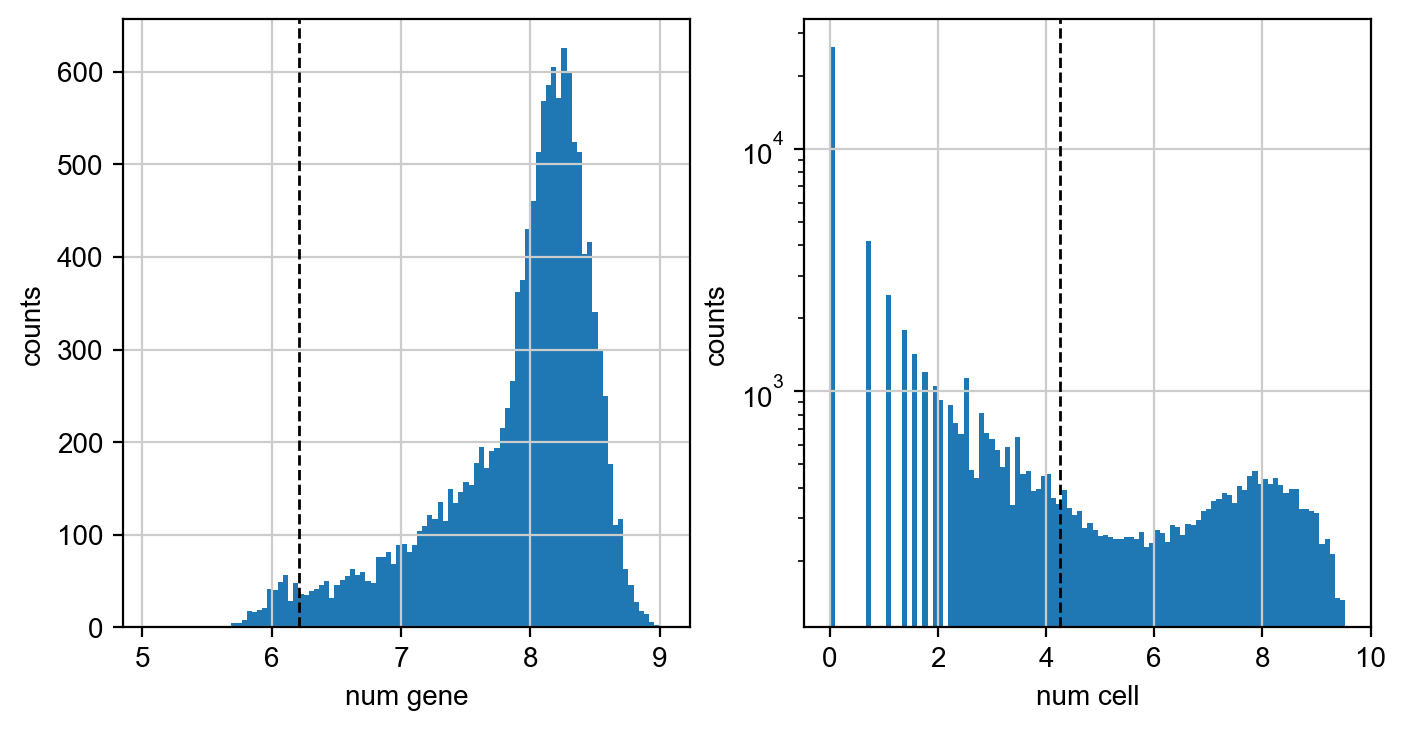

In [118]:
valX = adata.X>0
minGenes=500
minCells=70

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

numCellwExp = valX.sum(axis=1)
axs[0].hist(np.log(numCellwExp), bins=100)#, log=True)
axs[0].axvline(np.log(minGenes), color='k', linestyle='dashed', linewidth=1)
axs[0].set_xlabel('num gene')
axs[0].set_ylabel('counts')

numGeneswExp = valX.sum(axis=0).T
axs[1].hist(np.log(numGeneswExp+1), bins=100, log=True)
axs[1].axvline(np.log(minCells+1), color='k', linestyle='dashed', linewidth=1)
#axs[0,1].axvline(np.log(600), color='k', linestyle='dashed', linewidth=1)
#axs[0,1].axvline(np.log(4000), color='k', linestyle='dashed', linewidth=1)
#axs[0,1].set_title('Gene means counts')
axs[1].set_xlabel('num cell')
axs[1].set_ylabel('counts')

fig.show()

In [119]:
sc.pp.filter_cells(adata, min_genes = minGenes)
sc.pp.filter_genes(adata, min_cells = minCells)

filtered out 366 cells that have less than 500 genes expressed
filtered out 51750 genes that are detected in less than 70 cells


In [120]:
adata = adata[:,np.logical_not(adata.var_names=="GRCh38_MALAT1")]

In [121]:
adata.var['human'] = adata.var_names.str.startswith('GRCh38_') 
sc.pp.calculate_qc_metrics(adata, qc_vars=['human'], log1p = False, inplace=True)

/var/folders/nc/t9t85q_94q7g4tf0gz83qts40000gn/T/ipykernel_15760/989609383.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['human'] = adata.var_names.str.startswith('GRCh38_')


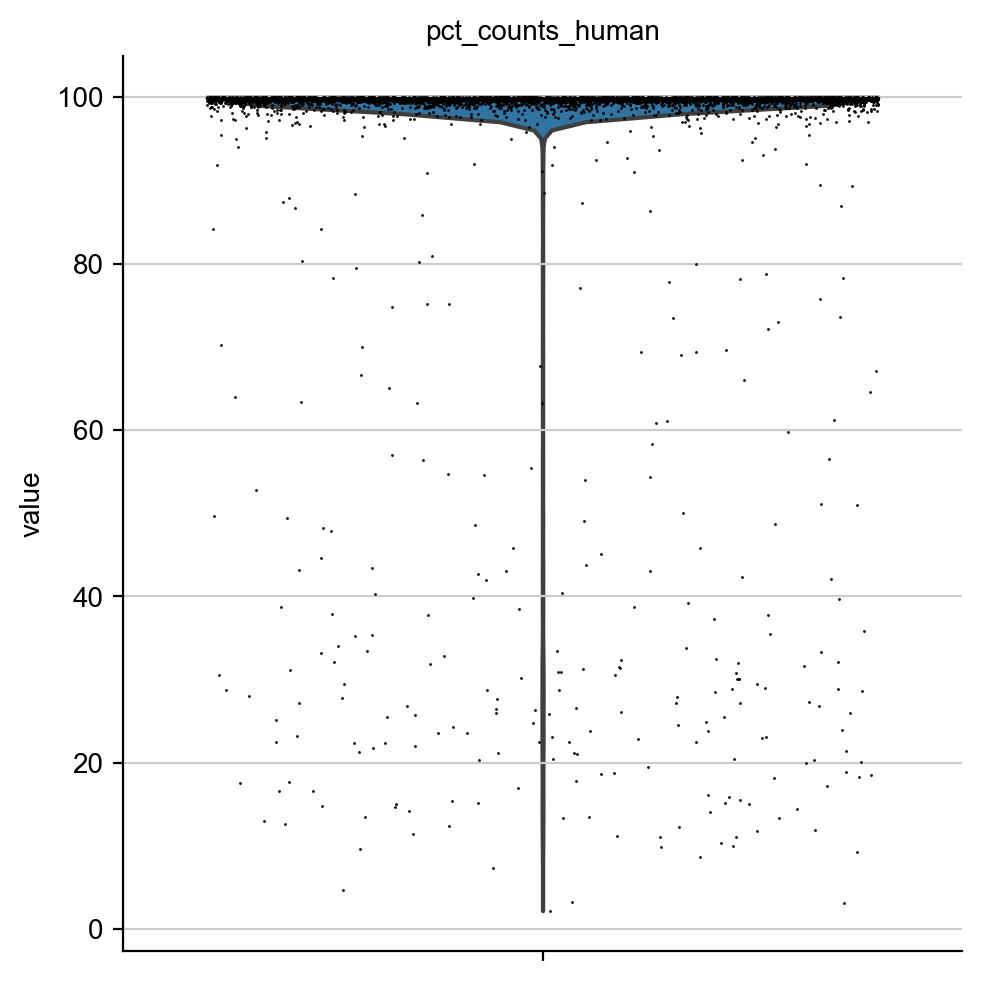

In [122]:
sc.pl.violin(adata, ['pct_counts_human'], jitter=0.4, multi_panel=True)

In [123]:
adata = adata[adata.obs.pct_counts_human > 99, :]

In [124]:
humanGenes = ['GRCh38_' in g for g in adata.var_names]
adata = adata[:,humanGenes]
humanGenes = [g.split("_")[1] for g in adata.var_names]
adata.var_names = humanGenes

In [125]:
adata.var_names

Index(['AL627309.5', 'AP006222.2', 'LINC01409', 'LINC01128', 'LINC00115',
       'FAM41C', 'SAMD11', 'NOC2L', 'KLHL17', 'PLEKHN1',
       ...
       'MT-ND6', 'MT-CYB', 'BX004987.1', 'MAFIP', 'AC011043.1', 'AL354822.1',
       'AL592183.1', 'AC240274.1', 'AC004556.3', 'AC007325.4'],
      dtype='object', length=16373)

In [126]:
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], log1p = False, inplace=True)

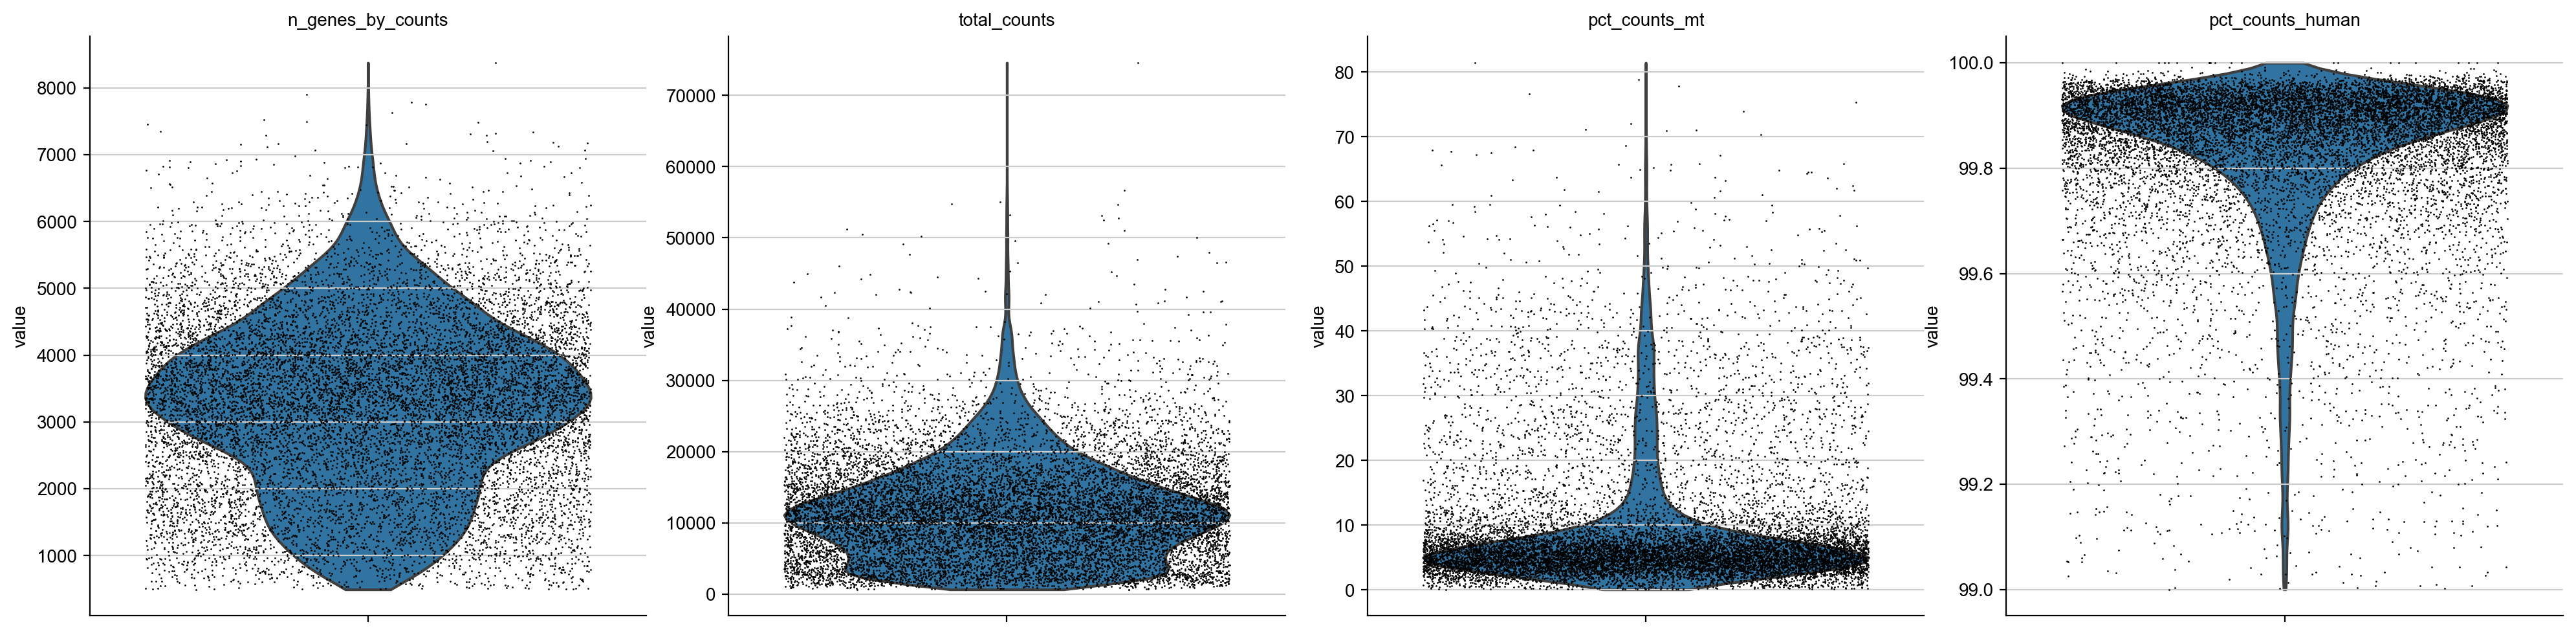

In [127]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_human'], jitter=0.4, multi_panel=True)

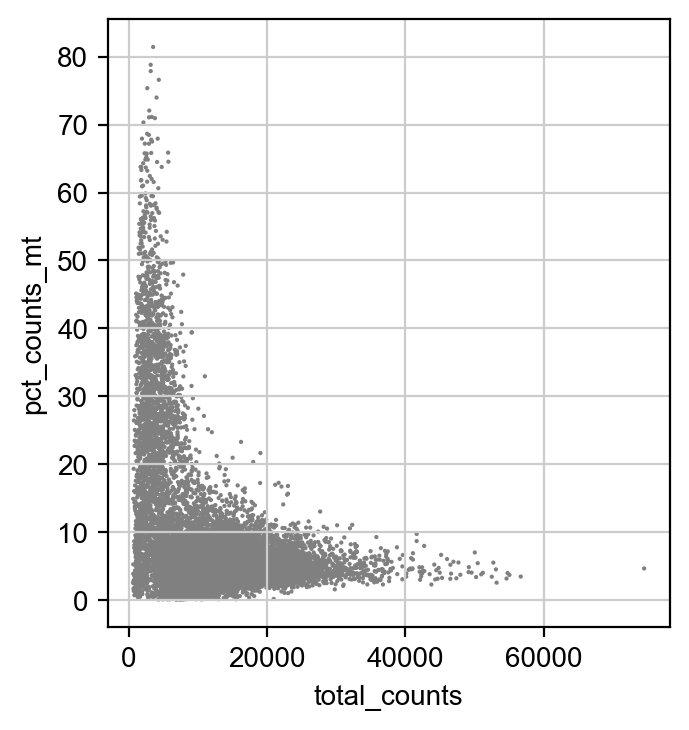

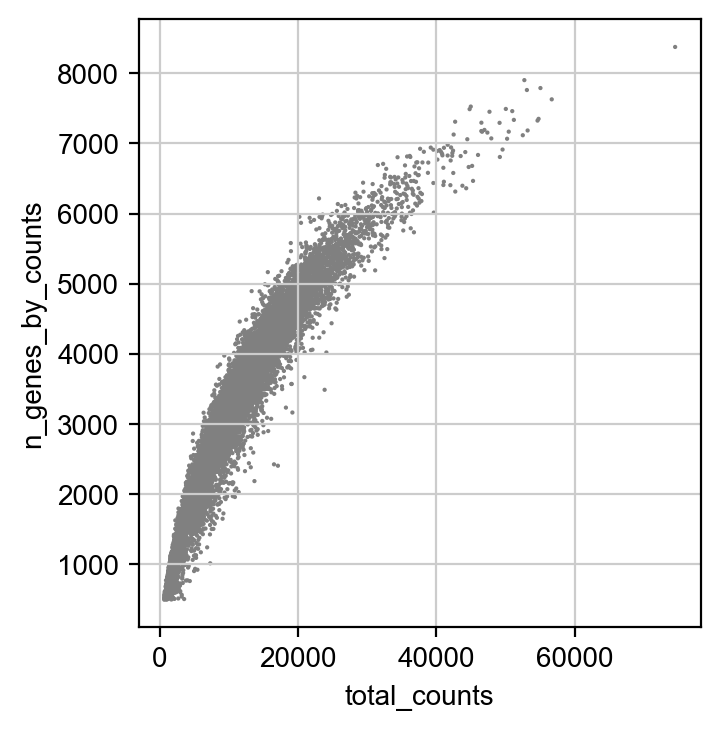

In [128]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [129]:
adata = adata[adata.obs.n_genes_by_counts < 5000, :]
adata = adata[adata.obs.total_counts < 25000, :]
adata = adata[adata.obs.pct_counts_mt < 15, :]

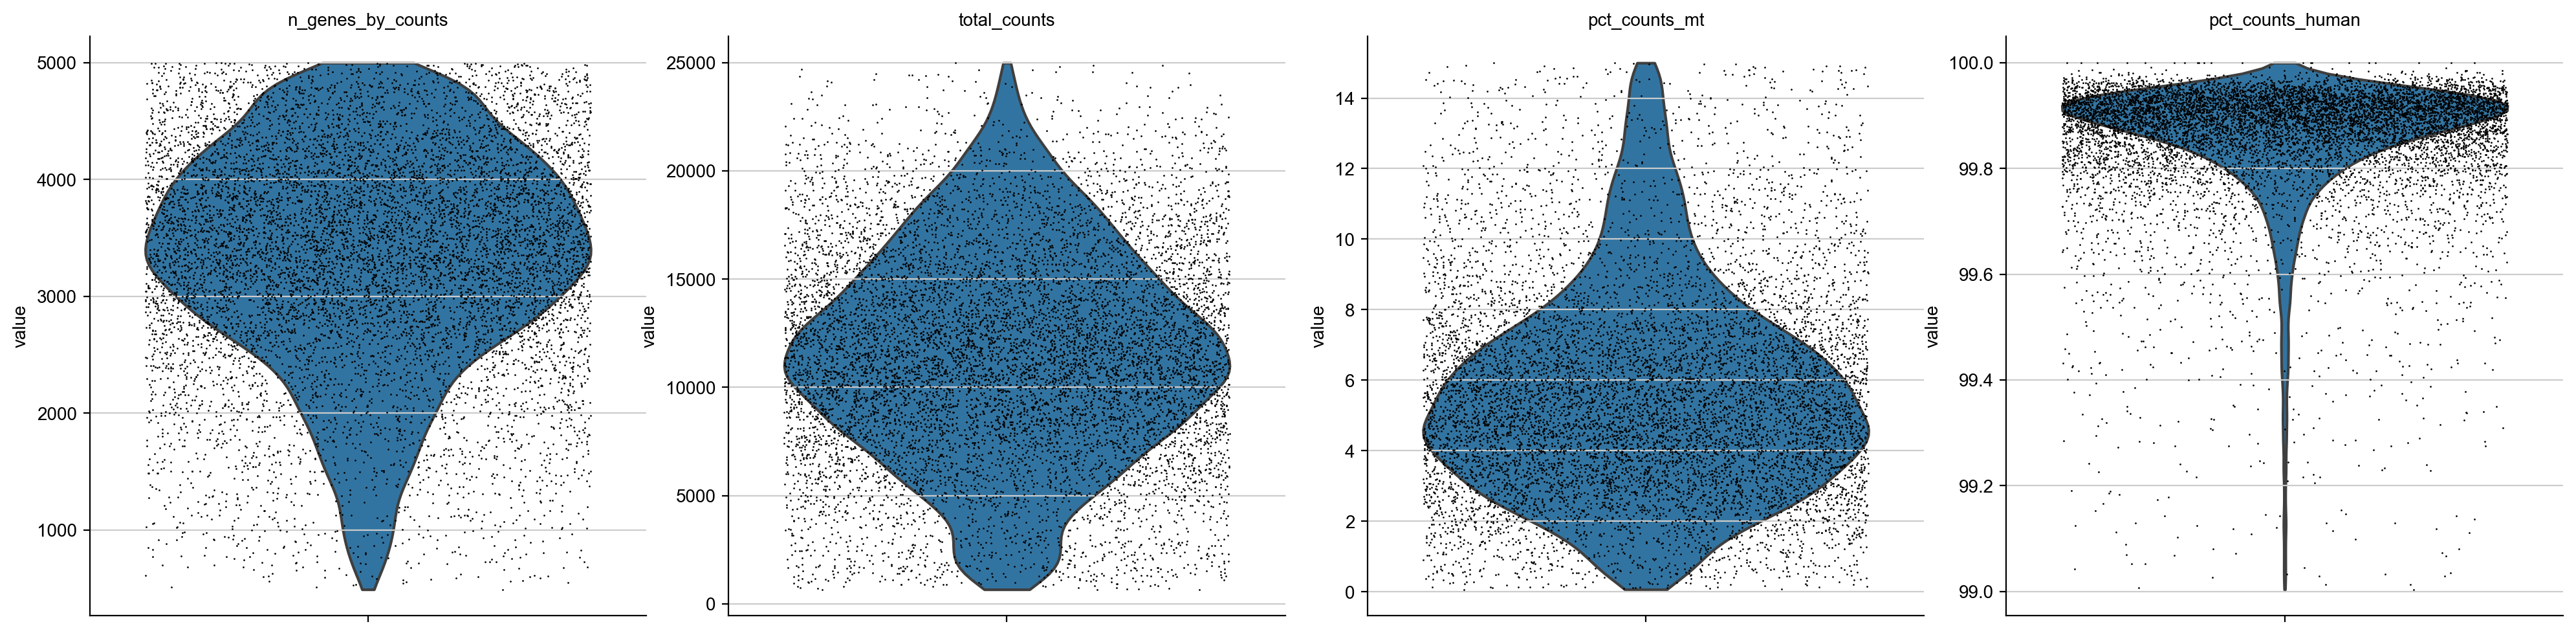

In [130]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_human'], jitter=0.4, multi_panel=True)

In [131]:
adata

View of AnnData object with n_obs × n_vars = 9687 × 16373
    obs: 'LX369-1_B0251', 'LX369-2_B0252', 'Ru699_B0253', 'LX29_B0254', 'LX278-1_B0255', 'LX278-2_B0256', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_human', 'pct_counts_human', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'human', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt'

In [132]:
hashes

['LX369-1_B0251',
 'LX369-2_B0252',
 'Ru699_B0253',
 'LX29_B0254',
 'LX278-1_B0255',
 'LX278-2_B0256']

In [133]:
import scanpy.external as sce
sce.pp.hashsolo(adata, hashes)
adata.obs.head()

Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/external/pp/_hashsolo.py:379: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["most_likely_hypothesis"] = results.loc[


LX369-1_B0251  LX369-2_B0252  Ru699_B0253  LX29_B0254  \
AAACCCAAGTGGTTGG-1            4.0            9.0         23.0      2455.0   
AAACCCACAGCGATTT-1            6.0         1252.0         64.0        47.0   
AAACCCACAGTAGTGG-1            5.0            4.0       1804.0        32.0   
AAACCCAGTGAGAACC-1            9.0            5.0         26.0        40.0   
AAACCCAGTTAAACAG-1            4.0           17.0         30.0        57.0   

                    LX278-1_B0255  LX278-2_B0256  n_genes  n_genes_by_counts  \
AAACCCAAGTGGTTGG-1           46.0           40.0     4740               4714   
AAACCCACAGCGATTT-1          110.0          812.0     2803               2785   
AAACCCACAGTAGTGG-1          315.0           46.0     4804               4788   
AAACCCAGTGAGAACC-1          103.0         6799.0     3813               3778   
AAACCCAGTTAAACAG-1        10830.0           38.0     4661               4616   

                    total_counts  pct_counts_in_top_50_genes  ...  \
AAACCCAAGTGGTTGG-1       20594.0                   23.293192  ...   
AAACCCACAGCGATTT-1       10112.0                   32.327927  ...   
AAACCCACAGTAGTGG-1       22677.0                   26.890682  ...   
AAACCCAGTGAGAACC-1       10895.0                   19.054612  ...   
AAACCCAGTTAAACAG-1       17594.0                   22.433784  ...   

                    total_counts_human  pct_counts_human  total_counts_mt  \
AAACCCAAGTGGTTGG-1             20594.0         99.922363            842.0   
AAACCCACAGCGATTT-1             10112.0         99.950577           1211.0   
AAACCCACAGTAGTGG-1             22677.0         99.881073            892.0   
AAACCCAGTGAGAACC-1             10895.0         99.926628            216.0   
AAACCCAGTTAAACAG-1             17594.0         99.914818            793.0   

                    pct_counts_mt  most_likely_hypothesis  cluster_feature  \
AAACCCAAGTGGTTGG-1       4.088570                       1                0   
AAACCCACAGCGATTT-1      11.975870                       2                0   
AAACCCACAGTAGTGG-1       3.933501                       1                0   
AAACCCAGTGAGAACC-1       1.982561                       1                0   
AAACCCAGTTAAACAG-1       4.507218                       1                0   

                    negative_hypothesis_probability  \
AAACCCAAGTGGTTGG-1                     4.731754e-16   
AAACCCACAGCGATTT-1                     8.474093e-17   
AAACCCACAGTAGTGG-1                     7.898151e-14   
AAACCCAGTGAGAACC-1                     2.977328e-17   
AAACCCAGTTAAACAG-1                     2.417819e-17   

                    singlet_hypothesis_probability  \
AAACCCAAGTGGTTGG-1                        1.000000   
AAACCCACAGCGATTT-1                        0.000011   
AAACCCACAGTAGTGG-1                        0.996608   
AAACCCAGTGAGAACC-1                        1.000000   
AAACCCAGTTAAACAG-1                        1.000000   

                    doublet_hypothesis_probability  Classification  
AAACCCAAGTGGTTGG-1                    7.359221e-13      LX29_B0254  
AAACCCACAGCGATTT-1                    9.999892e-01         Doublet  
AAACCCACAGTAGTGG-1                    3.391652e-03     Ru699_B0253  
AAACCCAGTGAGAACC-1                    2.777294e-09   LX278-2_B0256  
AAACCCAGTTAAACAG-1                    2.169358e-11   LX278-1_B0255  

[5 rows x 23 columns]

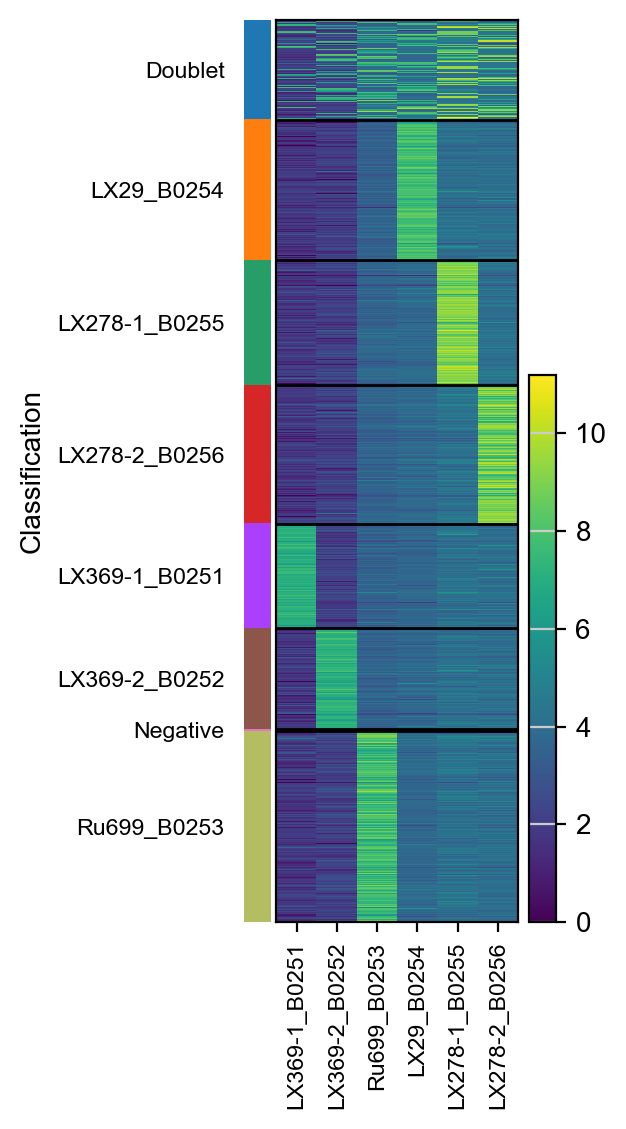

In [134]:
sc.pl.heatmap(adata,hashes,groupby="Classification",log=True)

In [135]:
from collections import Counter

Counter(adata.obs["Classification"])

Counter({'LX29_B0254': 1503,
         'Doublet': 1078,
         'Ru699_B0253': 2049,
         'LX278-2_B0256': 1486,
         'LX278-1_B0255': 1345,
         'LX369-1_B0251': 1119,
         'LX369-2_B0252': 1081,
         'Negative': 26})

In [136]:
singlets = [x in hashes for x in adata.obs["Classification"] ]
adata = adata[singlets,]
adata

View of AnnData object with n_obs × n_vars = 8583 × 16373
    obs: 'LX369-1_B0251', 'LX369-2_B0252', 'Ru699_B0253', 'LX29_B0254', 'LX278-1_B0255', 'LX278-2_B0256', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_human', 'pct_counts_human', 'total_counts_mt', 'pct_counts_mt', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'human', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt'
    uns: 'Classification_colors'

In [137]:
sc.pp.normalize_total(adata,target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [138]:
sc.pp.log1p(adata)

In [139]:
adatas.append(adata)

# 2

In [140]:
pdxName2

'PDX_LX55A_29A_369'

In [141]:
pdxFile = f"{inDir}{pdxName2}_filtered_feature_bc_matrix.h5"

In [142]:
adata = sc.read_10x_h5(pdxFile, gex_only=False)
adata

reading data/LUAD/PDX_LX55A_29A_369_filtered_feature_bc_matrix.h5
 (0:00:01)


/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 20074 × 68889
    var: 'gene_ids', 'feature_types', 'genome'

In [143]:
adata

AnnData object with n_obs × n_vars = 20074 × 68889
    var: 'gene_ids', 'feature_types', 'genome'

In [144]:
numHash = adata.var["feature_types"].value_counts()["Antibody Capture"]

In [145]:
hto = adata[:,-numHash:]
adata = adata[:,:-numHash]

In [146]:
hashes = list(hto.var.index)

In [147]:
hashdf = pd.DataFrame(hto.X.todense(), index=adata.obs_names ,columns=hashes)

In [148]:
adata.obs = adata.obs.join(hashdf)

/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [149]:
adata.var_names_make_unique()
adata.obs_names_make_unique()

normalizing counts per cell
    finished (0:00:00)


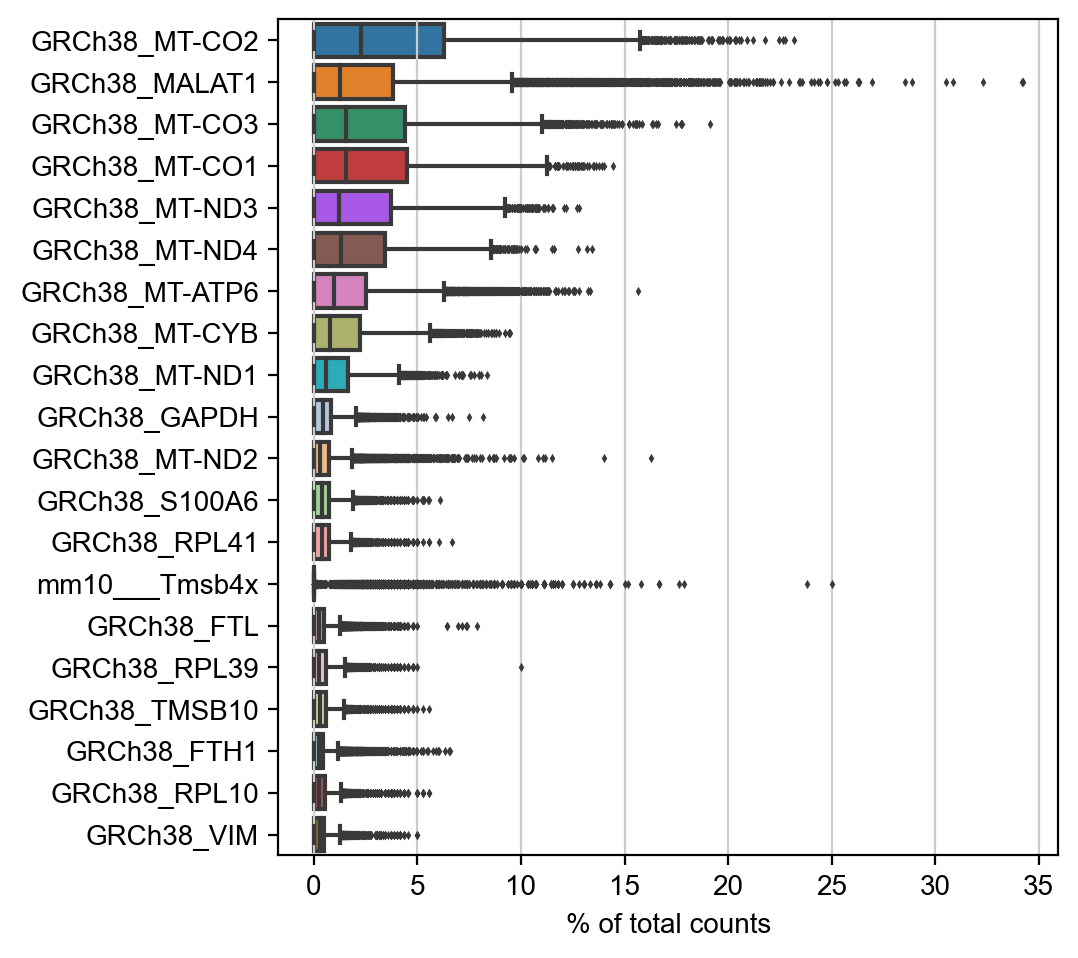

In [150]:
sc.pl.highest_expr_genes(adata, n_top=20, )

/var/folders/nc/t9t85q_94q7g4tf0gz83qts40000gn/T/ipykernel_15760/1541072668.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


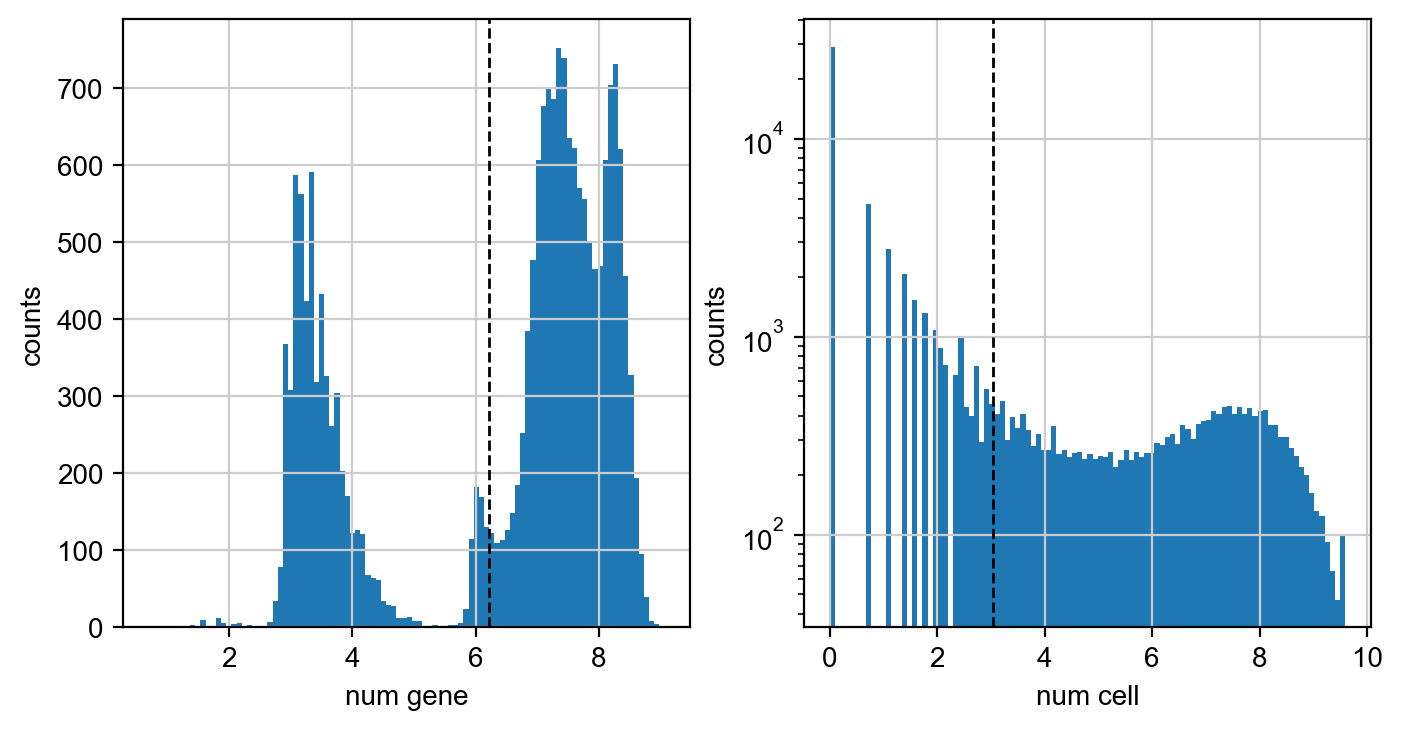

In [151]:
valX = adata.X>0
minGenes=500
minCells=20

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

numCellwExp = valX.sum(axis=1)
axs[0].hist(np.log(numCellwExp), bins=100)#, log=True)
axs[0].axvline(np.log(minGenes), color='k', linestyle='dashed', linewidth=1)
axs[0].set_xlabel('num gene')
axs[0].set_ylabel('counts')

numGeneswExp = valX.sum(axis=0).T
axs[1].hist(np.log(numGeneswExp+1), bins=100, log=True)
axs[1].axvline(np.log(minCells+1), color='k', linestyle='dashed', linewidth=1)
#axs[0,1].axvline(np.log(600), color='k', linestyle='dashed', linewidth=1)
#axs[0,1].axvline(np.log(4000), color='k', linestyle='dashed', linewidth=1)
#axs[0,1].set_title('Gene means counts')
axs[1].set_xlabel('num cell')
axs[1].set_ylabel('counts')

fig.show()

In [152]:
sc.pp.filter_cells(adata, min_genes = minGenes)
sc.pp.filter_genes(adata, min_cells = minCells)

filtered out 6372 cells that have less than 500 genes expressed
filtered out 50040 genes that are detected in less than 20 cells


In [153]:
adata = adata[:,np.logical_not(adata.var_names=="GRCh38_MALAT1")]

In [154]:
adata.var['human'] = adata.var_names.str.startswith('GRCh38_') 
sc.pp.calculate_qc_metrics(adata, qc_vars=['human'], log1p = False, inplace=True)

/var/folders/nc/t9t85q_94q7g4tf0gz83qts40000gn/T/ipykernel_15760/989609383.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['human'] = adata.var_names.str.startswith('GRCh38_')


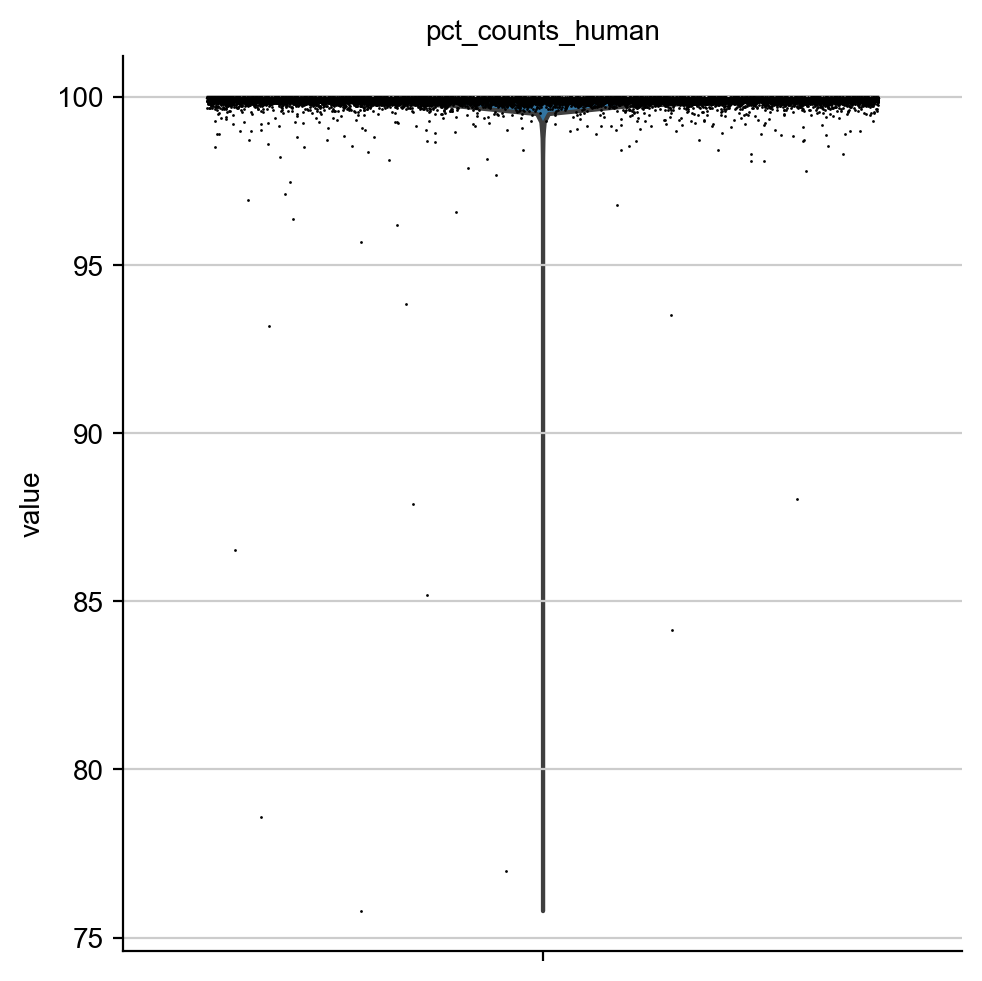

In [155]:
sc.pl.violin(adata, ['pct_counts_human'], jitter=0.4, multi_panel=True)

In [156]:
adata = adata[adata.obs.pct_counts_human > 99, :]

In [157]:
humanGenes = ['GRCh38_' in g for g in adata.var_names]
adata = adata[:,humanGenes]
humanGenes = [g.split("_")[1] for g in adata.var_names]
adata.var_names = humanGenes

In [158]:
adata.var_names

Index(['AL627309.1', 'AL627309.5', 'LINC01409', 'FAM87B', 'LINC01128',
       'LINC00115', 'FAM41C', 'AL645608.2', 'SAMD11', 'NOC2L',
       ...
       'MT-ND6', 'MT-CYB', 'BX004987.1', 'MAFIP', 'AC011043.1', 'AL354822.1',
       'AL592183.1', 'AC240274.1', 'AC004556.3', 'AC007325.4'],
      dtype='object', length=18594)

In [159]:
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], log1p = False, inplace=True)

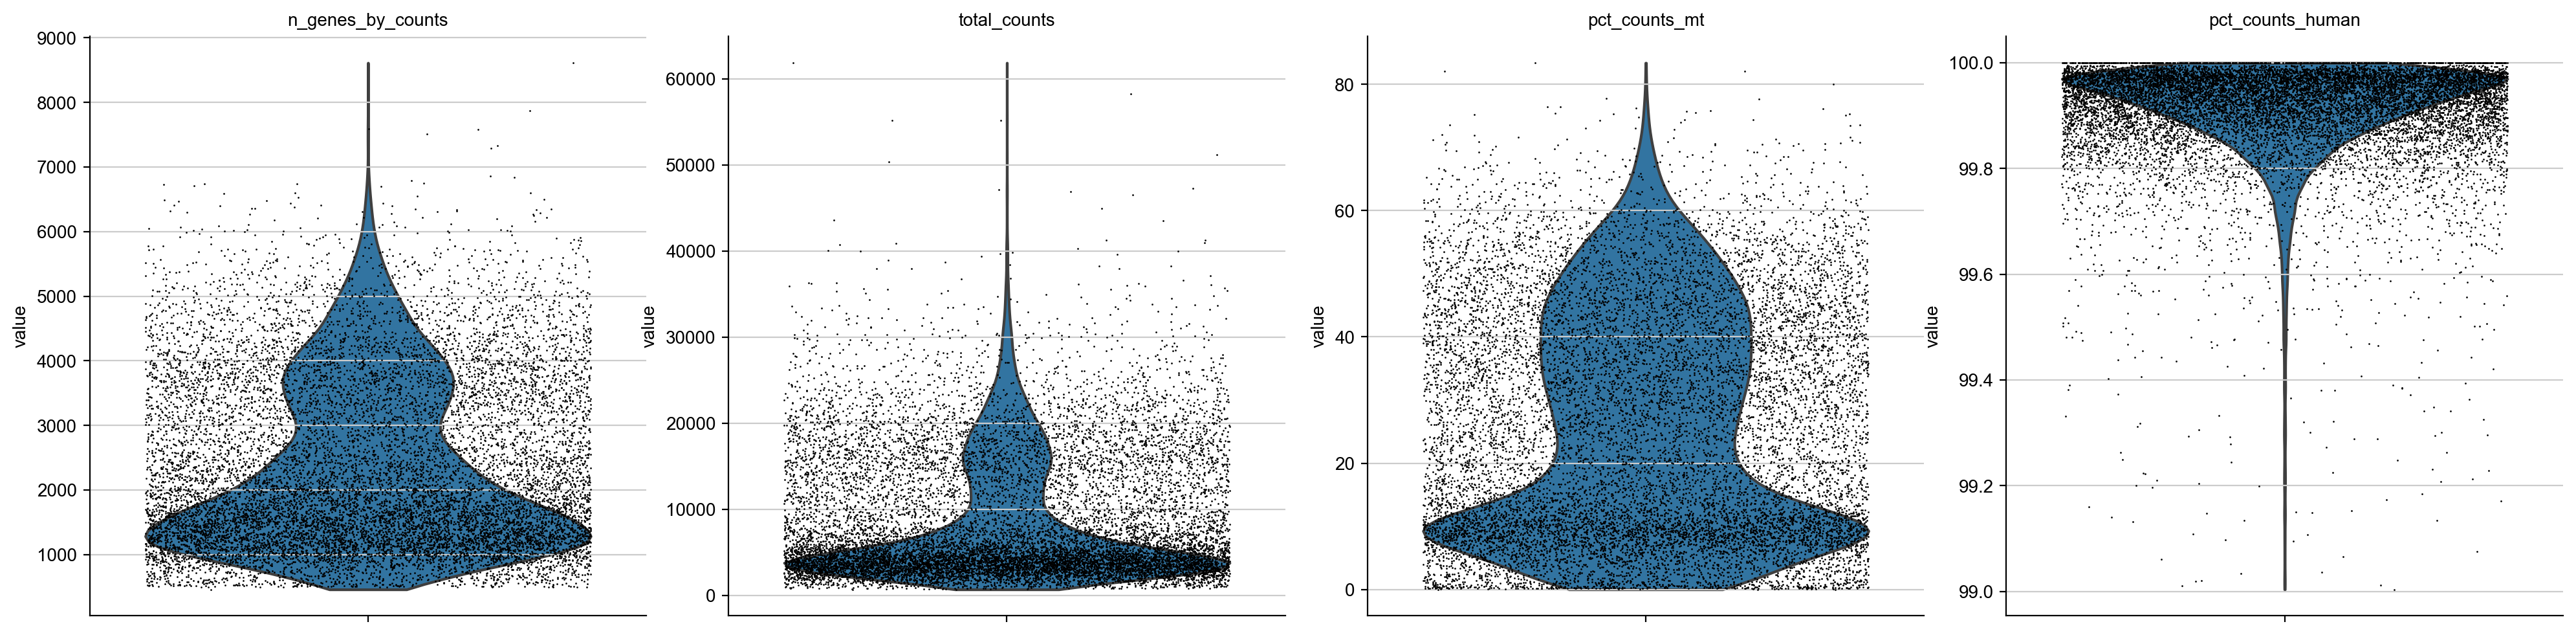

In [160]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_human'], jitter=0.4, multi_panel=True)

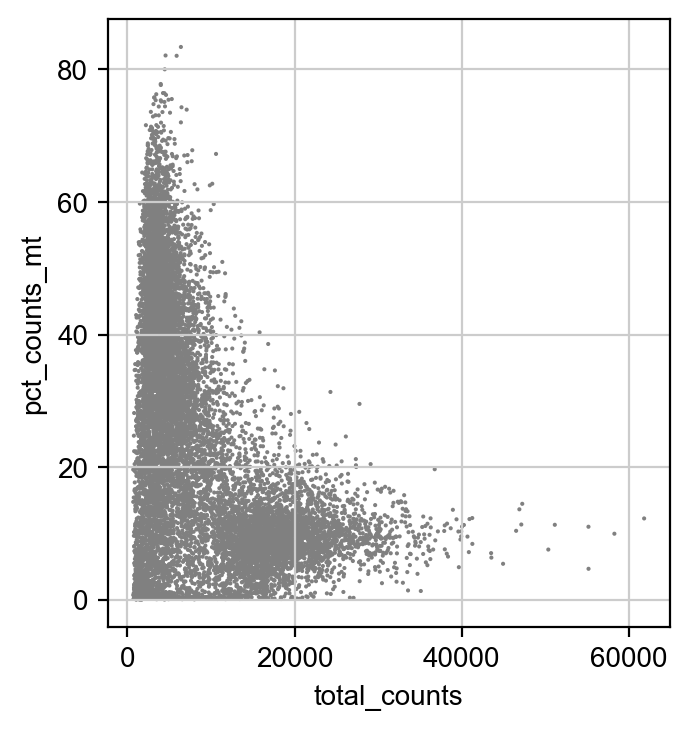

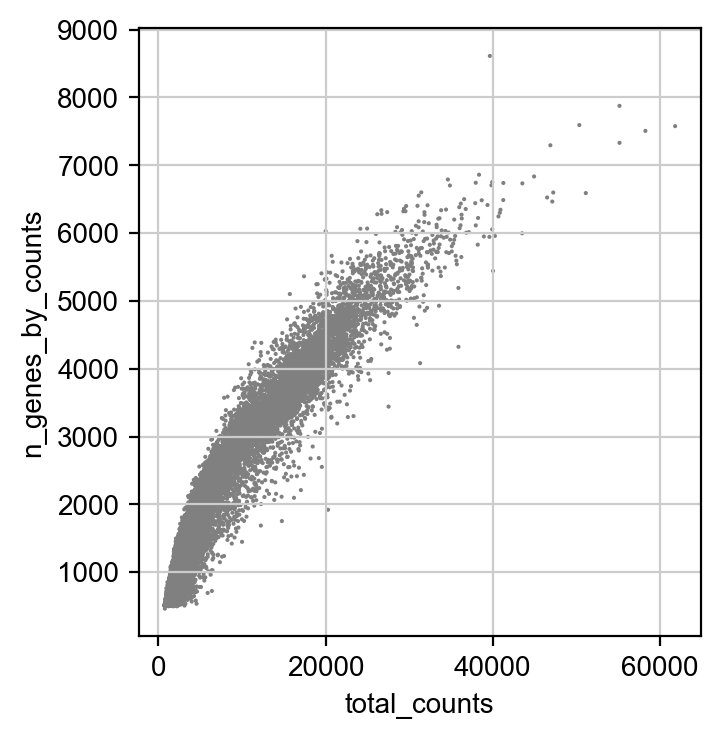

In [161]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [162]:
adata = adata[adata.obs.n_genes_by_counts < 5000, :]
adata = adata[adata.obs.total_counts < 25000, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]

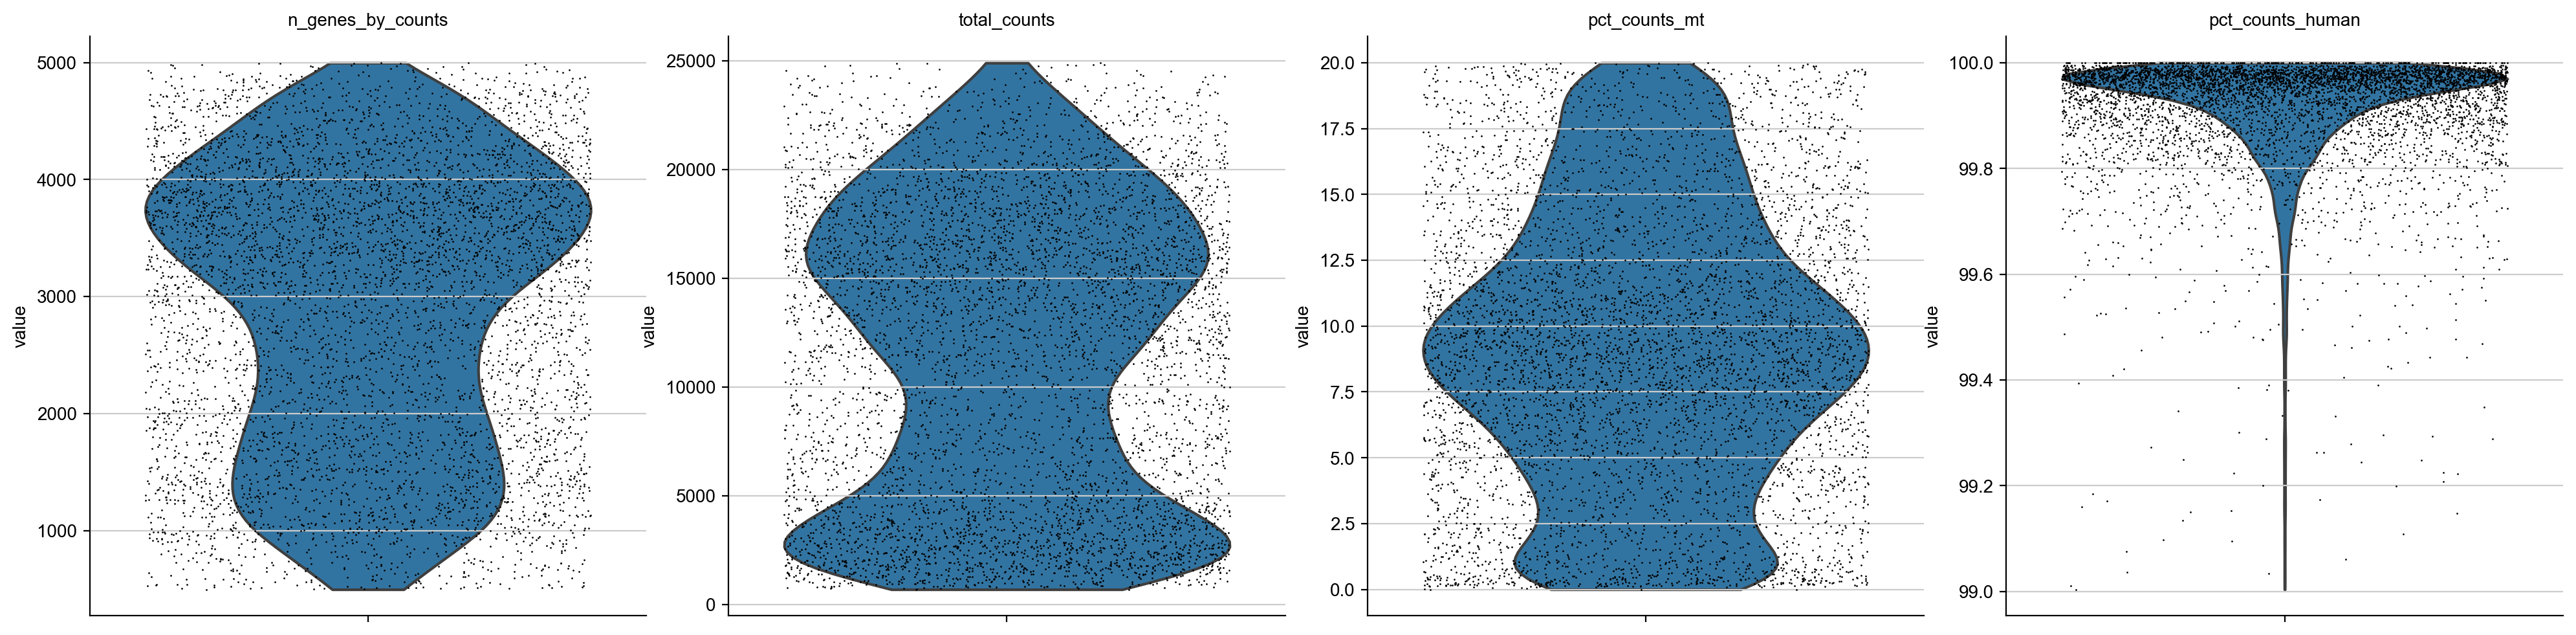

In [163]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_human'], jitter=0.4, multi_panel=True)

In [164]:
adata

View of AnnData object with n_obs × n_vars = 5780 × 18594
    obs: 'LX55A_B0251', 'LX29A_B0252', 'LX369_B0253', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_human', 'pct_counts_human', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'human', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt'

In [165]:
hashes

['LX55A_B0251', 'LX29A_B0252', 'LX369_B0253']

In [166]:
sce.pp.hashsolo(adata, hashes)
adata.obs.head()

Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/external/pp/_hashsolo.py:379: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["most_likely_hypothesis"] = results.loc[


LX55A_B0251  LX29A_B0252  LX369_B0253  n_genes  \
AAACCCAAGAAATCCA-1         34.0       1777.0         64.0     1405   
AAACCCAAGCCACCGT-1         69.0         57.0       5030.0     1913   
AAACCCACAAACACGG-1         74.0         65.0       2845.0     1383   
AAACCCACAGAGATTA-1       4152.0         45.0         82.0     3640   
AAACCCACATGATGCT-1         50.0         51.0       3127.0     3494   

                    n_genes_by_counts  total_counts  \
AAACCCAAGAAATCCA-1               1394        5557.0   
AAACCCAAGCCACCGT-1               1907        3545.0   
AAACCCACAAACACGG-1               1379        2729.0   
AAACCCACAGAGATTA-1               3621       15090.0   
AAACCCACATGATGCT-1               3488       10374.0   

                    pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
AAACCCAAGAAATCCA-1                   41.965089                    58.880691   
AAACCCAAGCCACCGT-1                   25.726375                    33.286319   
AAACCCACAAACACGG-1                   29.681202                    38.878710   
AAACCCACAGAGATTA-1                   34.406892                    48.774023   
AAACCCACATGATGCT-1                   24.966262                    34.808174   

                    pct_counts_in_top_200_genes  pct_counts_in_top_500_genes  \
AAACCCAAGAAATCCA-1                    69.857837                    82.994421   
AAACCCAAGCCACCGT-1                    42.595205                    60.169252   
AAACCCACAAACACGG-1                    50.238182                    67.790399   
AAACCCACAGAGATTA-1                    58.681246                    69.675282   
AAACCCACATGATGCT-1                    44.756121                    59.572007   

                    total_counts_human  pct_counts_human  total_counts_mt  \
AAACCCAAGAAATCCA-1              5557.0         99.641380            418.0   
AAACCCAAGCCACCGT-1              3545.0         99.690666            412.0   
AAACCCACAAACACGG-1              2729.0         99.780617            373.0   
AAACCCACAGAGATTA-1             15090.0         99.940399            548.0   
AAACCCACATGATGCT-1             10374.0         99.865227             82.0   

                    pct_counts_mt  most_likely_hypothesis  cluster_feature  \
AAACCCAAGAAATCCA-1       7.522044                       1                0   
AAACCCAAGCCACCGT-1      11.622003                       1                0   
AAACCCACAAACACGG-1      13.668010                       1                0   
AAACCCACAGAGATTA-1       3.631544                       1                0   
AAACCCACATGATGCT-1       0.790438                       1                0   

                    negative_hypothesis_probability  \
AAACCCAAGAAATCCA-1                     9.466130e-11   
AAACCCAAGCCACCGT-1                     3.214801e-17   
AAACCCACAAACACGG-1                     4.119678e-17   
AAACCCACAGAGATTA-1                     1.893215e-15   
AAACCCACATGATGCT-1                     2.705692e-17   

                    singlet_hypothesis_probability  \
AAACCCAAGAAATCCA-1                        0.999993   
AAACCCAAGCCACCGT-1                        1.000000   
AAACCCACAAACACGG-1                        1.000000   
AAACCCACAGAGATTA-1                        0.999973   
AAACCCACATGATGCT-1                        0.999989   

                    doublet_hypothesis_probability Classification  
AAACCCAAGAAATCCA-1                    7.313258e-06    LX29A_B0252  
AAACCCAAGCCACCGT-1                    4.018272e-08    LX369_B0253  
AAACCCACAAACACGG-1                    8.210422e-08    LX369_B0253  
AAACCCACAGAGATTA-1                    2.729663e-05    LX55A_B0251  
AAACCCACATGATGCT-1                    1.093221e-05    LX369_B0253

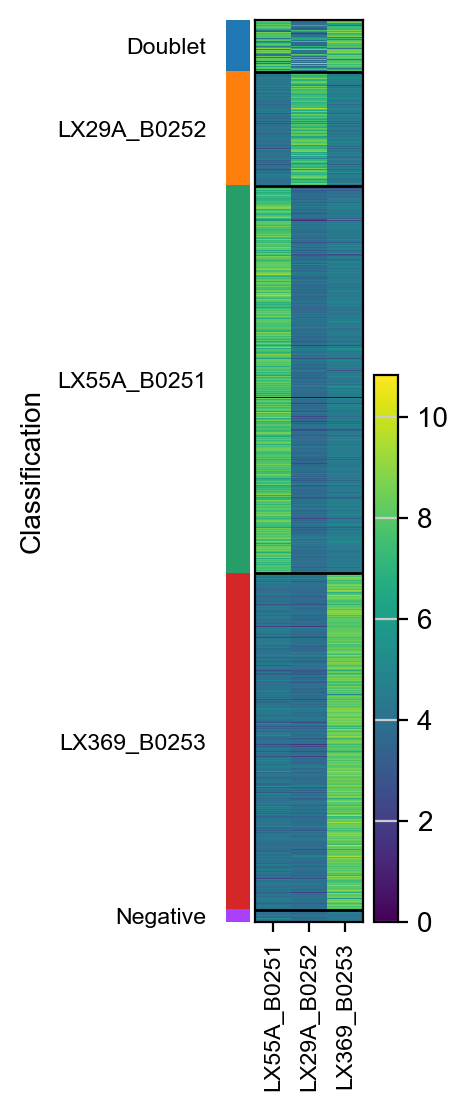

In [167]:
sc.pl.heatmap(adata,hashes,groupby="Classification",log=True)

In [168]:
Counter(adata.obs["Classification"])

Counter({'LX29A_B0252': 726,
         'LX369_B0253': 2154,
         'LX55A_B0251': 2484,
         'Doublet': 335,
         'Negative': 81})

In [169]:
singlets = [x in hashes for x in adata.obs["Classification"] ]
adata = adata[singlets,]
adata

View of AnnData object with n_obs × n_vars = 5364 × 18594
    obs: 'LX55A_B0251', 'LX29A_B0252', 'LX369_B0253', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_human', 'pct_counts_human', 'total_counts_mt', 'pct_counts_mt', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'human', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt'
    uns: 'Classification_colors'

In [170]:
sc.pp.normalize_total(adata,target_sum=1e4)

/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


normalizing counts per cell
    finished (0:00:00)


In [171]:
sc.pp.log1p(adata)

In [172]:
adatas.append(adata)

# 3

In [173]:
pdxFile = f"{inDir}{pdxName3}_filtered_feature_bc_matrix.h5"

In [174]:
adata = sc.read_10x_h5(pdxFile, gex_only=False)
adata

reading data/LUAD/PDX_Ru465_210_318_filtered_feature_bc_matrix.h5
 (0:00:01)


/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 20439 × 68892
    var: 'gene_ids', 'feature_types', 'genome'

In [175]:
numHash = adata.var["feature_types"].value_counts()["Antibody Capture"]

In [176]:
hto = adata[:,-numHash:]
adata = adata[:,:-numHash]

In [177]:
hashes = list(hto.var.index)

In [178]:
hashdf = pd.DataFrame(hto.X.todense(), index=adata.obs_names ,columns=hashes)

In [179]:
adata.obs = adata.obs.join(hashdf)

/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [180]:
adata.var_names_make_unique()
adata.obs_names_make_unique()

normalizing counts per cell
    finished (0:00:00)


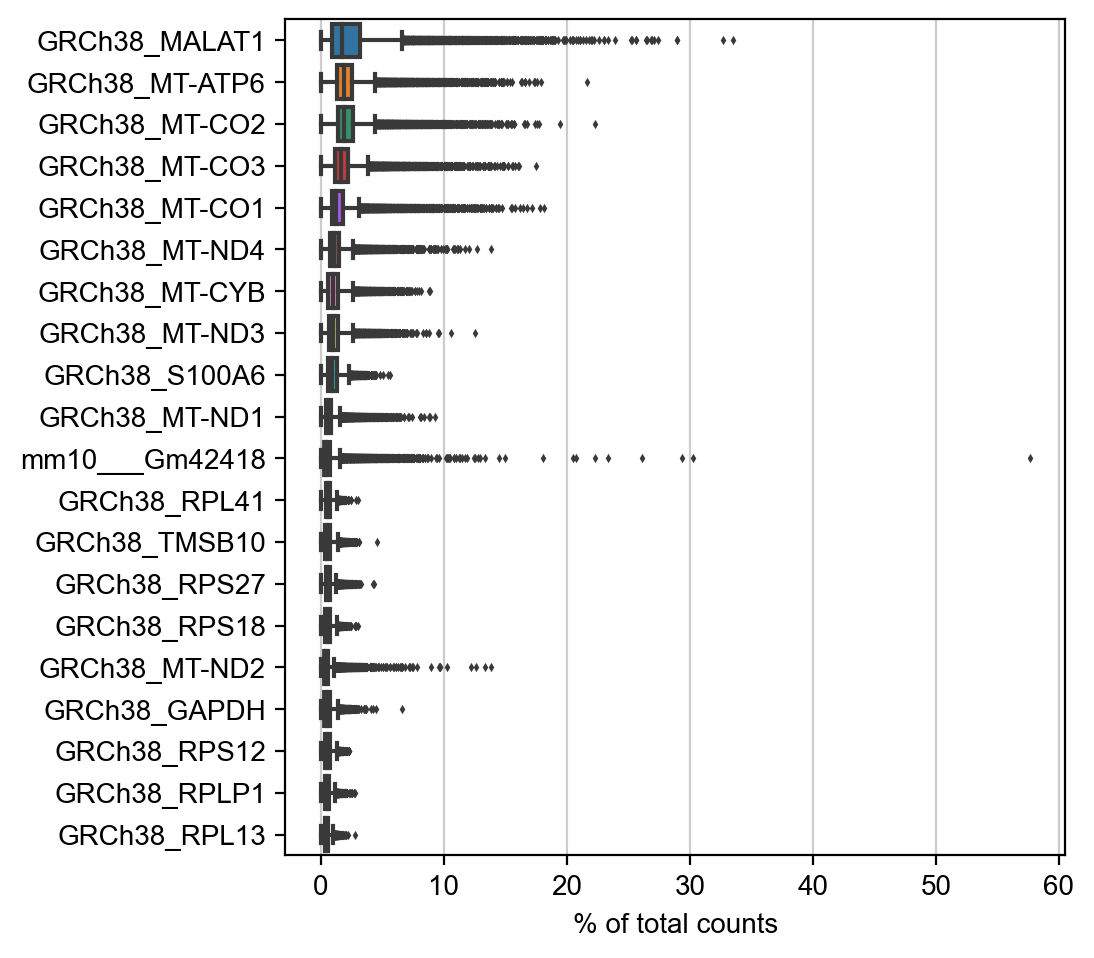

In [181]:
sc.pl.highest_expr_genes(adata, n_top=20, )

/var/folders/nc/t9t85q_94q7g4tf0gz83qts40000gn/T/ipykernel_15760/2123468045.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


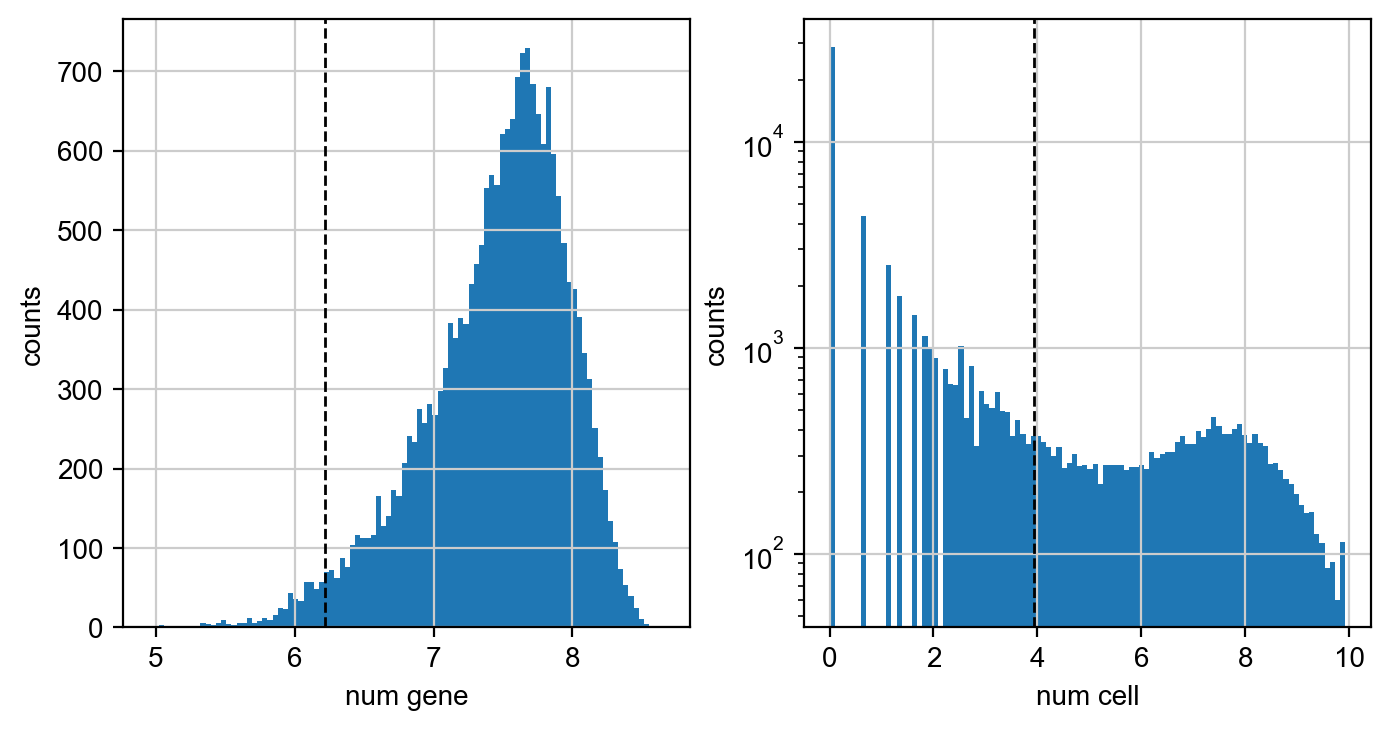

In [182]:
valX = adata.X>0
minGenes=500
minCells=50

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

numCellwExp = valX.sum(axis=1)
axs[0].hist(np.log(numCellwExp), bins=100)#, log=True)
axs[0].axvline(np.log(minGenes), color='k', linestyle='dashed', linewidth=1)
axs[0].set_xlabel('num gene')
axs[0].set_ylabel('counts')

numGeneswExp = valX.sum(axis=0).T
axs[1].hist(np.log(numGeneswExp+1), bins=100, log=True)
axs[1].axvline(np.log(minCells+1), color='k', linestyle='dashed', linewidth=1)
#axs[0,1].axvline(np.log(600), color='k', linestyle='dashed', linewidth=1)
#axs[0,1].axvline(np.log(4000), color='k', linestyle='dashed', linewidth=1)
#axs[0,1].set_title('Gene means counts')
axs[1].set_xlabel('num cell')
axs[1].set_ylabel('counts')

fig.show()

In [183]:
sc.pp.filter_cells(adata, min_genes = minGenes)
sc.pp.filter_genes(adata, min_cells = minCells)

filtered out 504 cells that have less than 500 genes expressed
filtered out 51705 genes that are detected in less than 50 cells


In [184]:
adata = adata[:,np.logical_not(adata.var_names=="GRCh38_MALAT1")]

In [185]:
adata.var['human'] = adata.var_names.str.startswith('GRCh38_') 
sc.pp.calculate_qc_metrics(adata, qc_vars=['human'], log1p = False, inplace=True)

/var/folders/nc/t9t85q_94q7g4tf0gz83qts40000gn/T/ipykernel_15760/989609383.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['human'] = adata.var_names.str.startswith('GRCh38_')


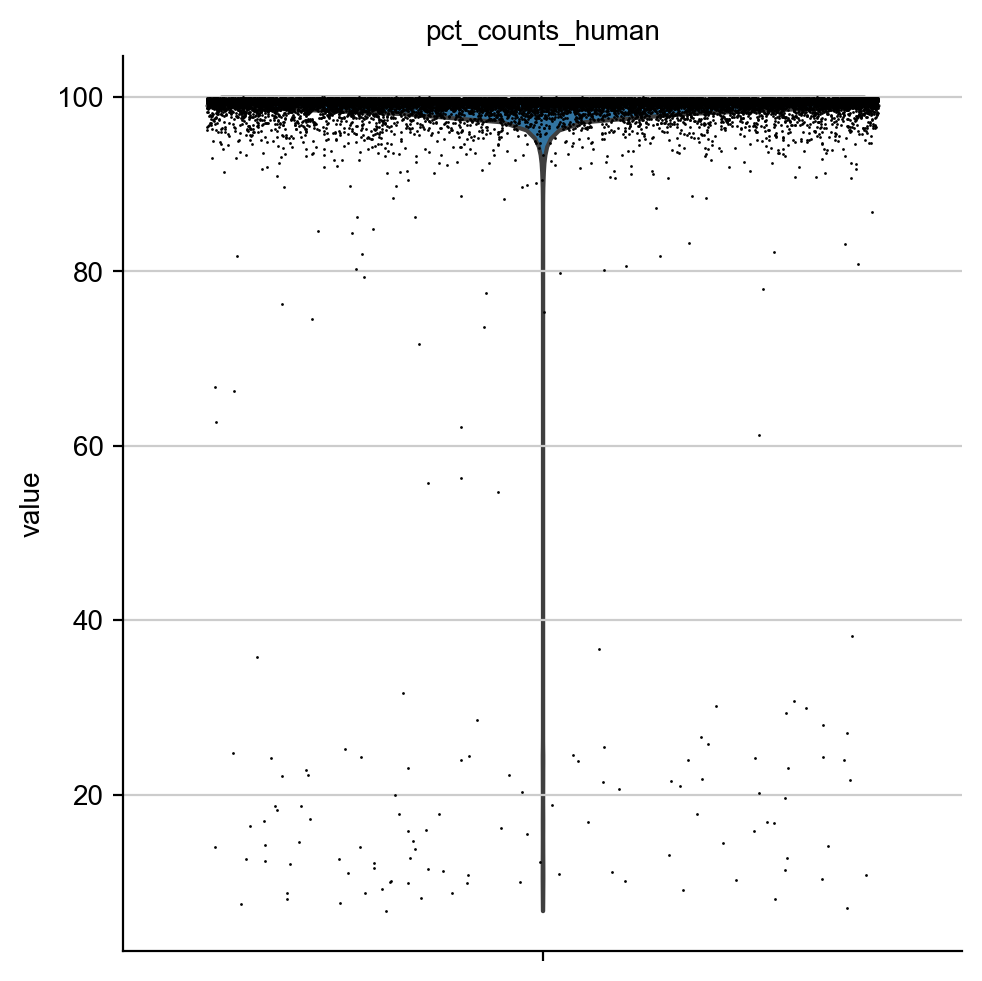

In [186]:
sc.pl.violin(adata, ['pct_counts_human'], jitter=0.4, multi_panel=True)

In [187]:
adata = adata[adata.obs.pct_counts_human > 99, :]

In [188]:
humanGenes = ['GRCh38_' in g for g in adata.var_names]
adata = adata[:,humanGenes]
humanGenes = [g.split("_")[1] for g in adata.var_names]
adata.var_names = humanGenes

In [189]:
adata.var_names

Index(['AL627309.5', 'LINC01409', 'LINC01128', 'LINC00115', 'FAM41C', 'SAMD11',
       'NOC2L', 'KLHL17', 'PLEKHN1', 'PERM1',
       ...
       'MT-ND5', 'MT-ND6', 'MT-CYB', 'BX004987.1', 'MAFIP', 'AC011043.1',
       'AL354822.1', 'AC240274.1', 'AC004556.3', 'AC007325.4'],
      dtype='object', length=16381)

In [190]:
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], log1p = False, inplace=True)

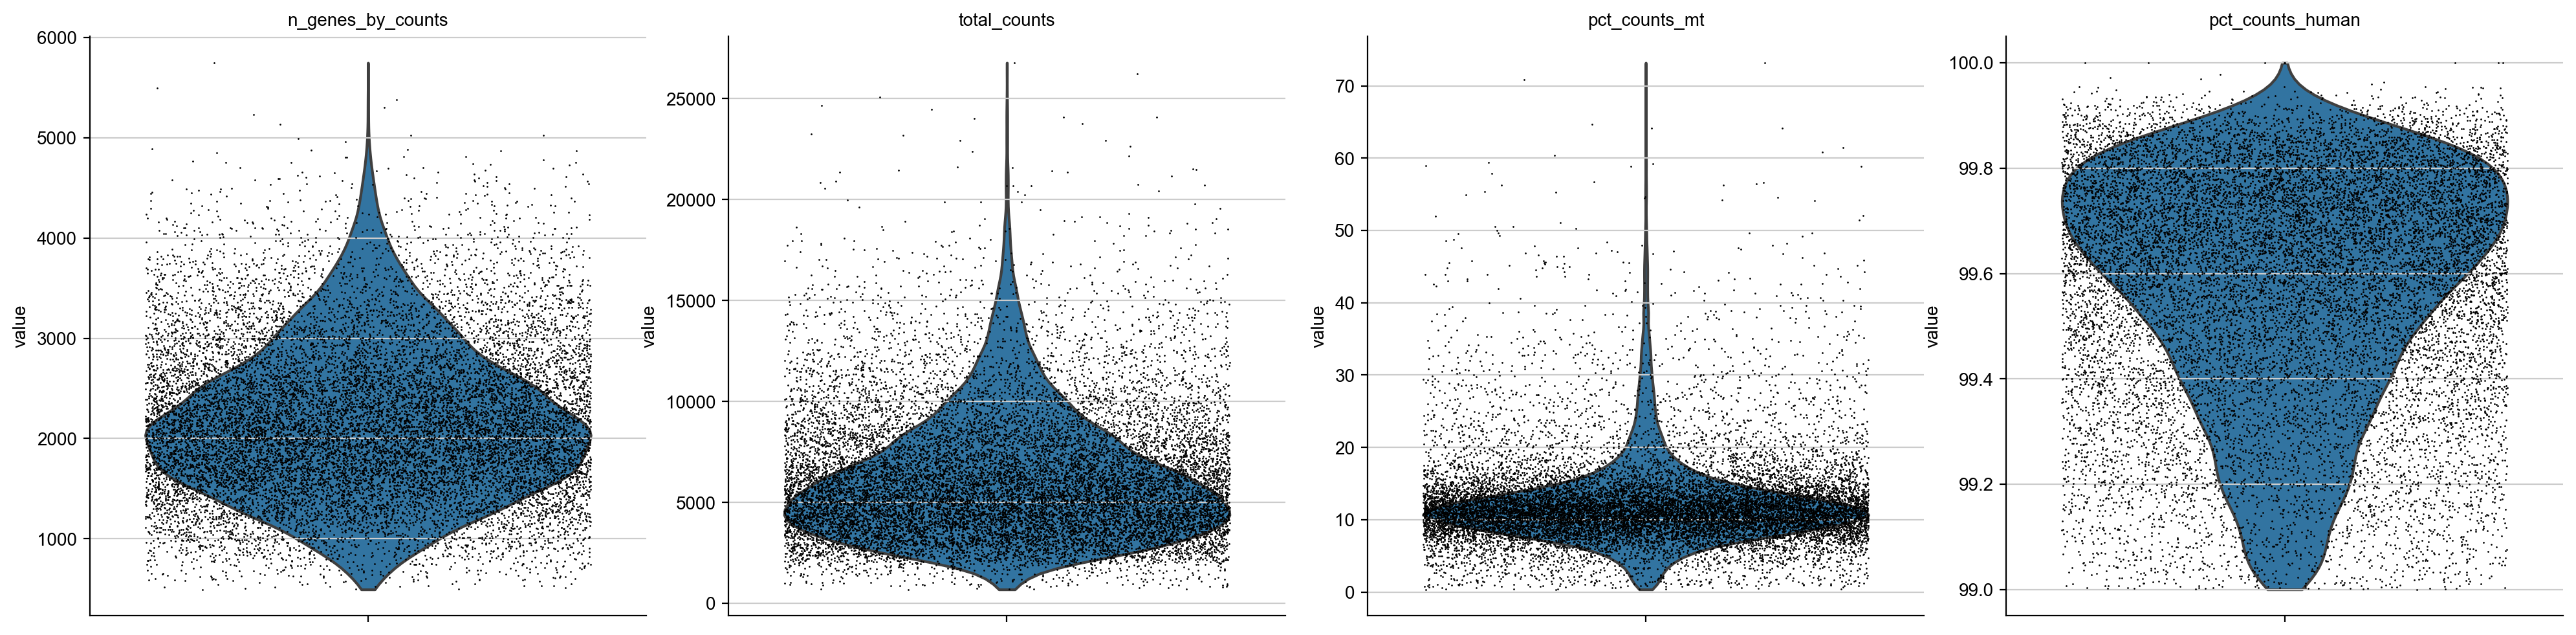

In [191]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_human'], jitter=0.4, multi_panel=True)

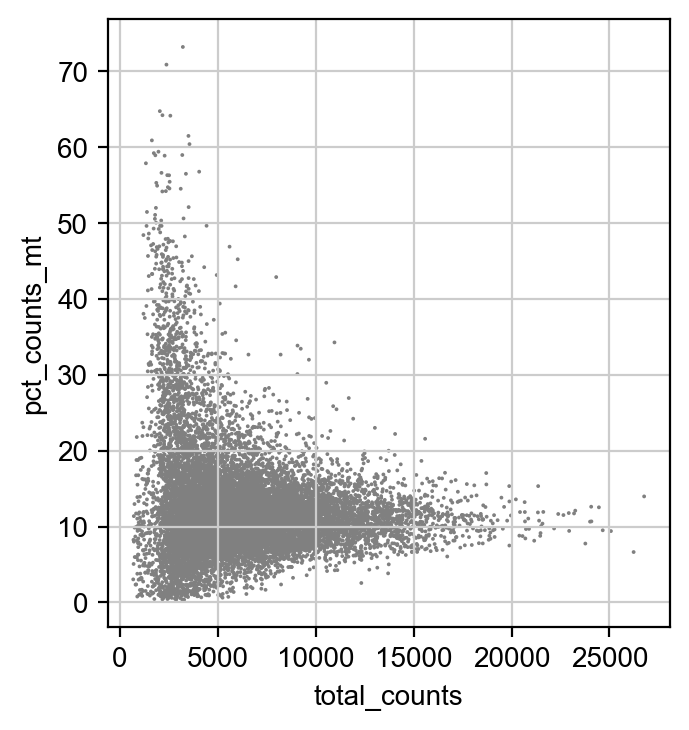

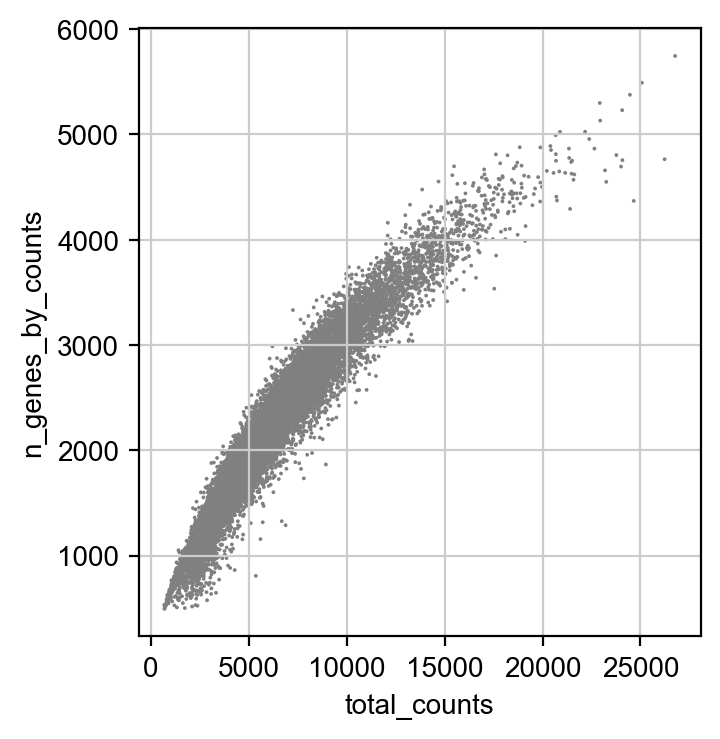

In [192]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [193]:
adata = adata[adata.obs.n_genes_by_counts < 5000, :]
adata = adata[adata.obs.total_counts < 15000, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]

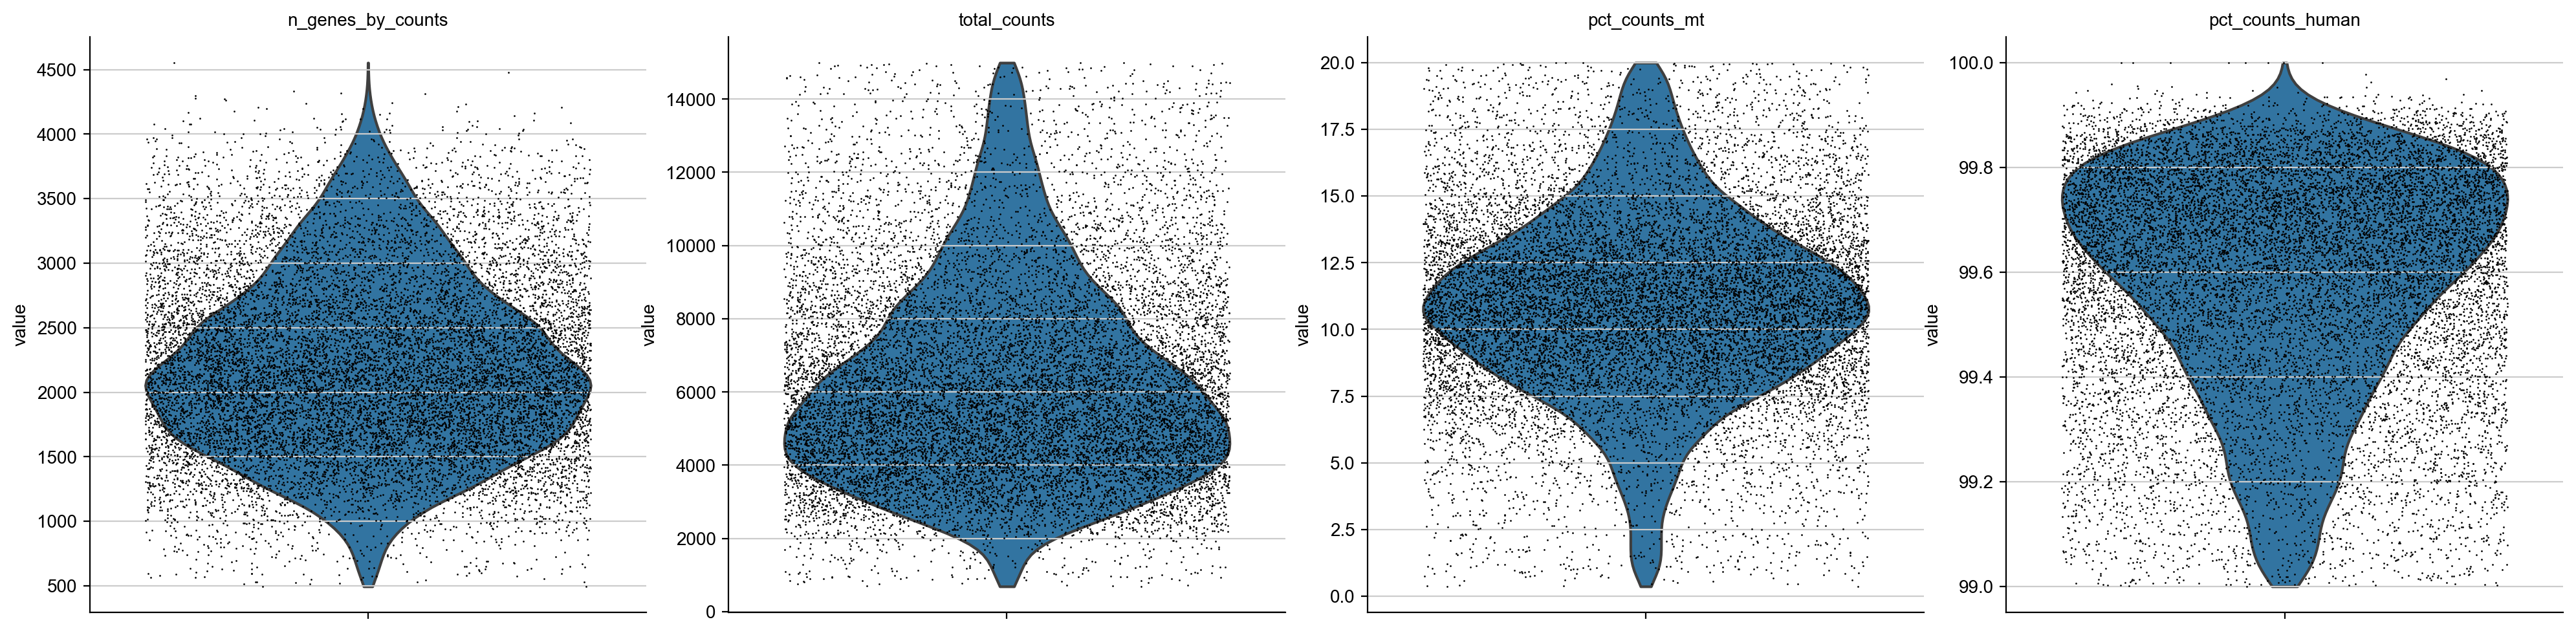

In [194]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_human'], jitter=0.4, multi_panel=True)

In [195]:
adata

View of AnnData object with n_obs × n_vars = 14401 × 16381
    obs: 'Ru465-1_B0251', 'Ru465-2_B0252', 'Ru210-L_B0253', 'Ru210-R', 'Ru318-L_B0255', 'Ru318-R_B0256', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_human', 'pct_counts_human', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'human', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt'

In [196]:
hashes

['Ru465-1_B0251',
 'Ru465-2_B0252',
 'Ru210-L_B0253',
 'Ru210-R',
 'Ru318-L_B0255',
 'Ru318-R_B0256']

In [197]:
import scanpy.external as sce
sce.pp.hashsolo(adata, hashes)
adata.obs.head()

Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/external/pp/_hashsolo.py:379: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["most_likely_hypothesis"] = results.loc[


Ru465-1_B0251  Ru465-2_B0252  Ru210-L_B0253  Ru210-R  \
AAACCCAAGACATCCT-1         1848.0           48.0           10.0   4405.0   
AAACCCAAGCATGTTC-1           58.0           44.0         2748.0     22.0   
AAACCCACAAGCAATA-1         2099.0           46.0           11.0     30.0   
AAACCCACAAGGCGTA-1           44.0         2338.0           15.0     19.0   
AAACCCACAGCGTGAA-1         2341.0          117.0           26.0     39.0   

                    Ru318-L_B0255  Ru318-R_B0256  n_genes  n_genes_by_counts  \
AAACCCAAGACATCCT-1            9.0            2.0     3563               3545   
AAACCCAAGCATGTTC-1            6.0            5.0     2010               1994   
AAACCCACAAGCAATA-1            4.0            7.0     2434               2426   
AAACCCACAAGGCGTA-1          314.0            7.0     4333               4311   
AAACCCACAGCGTGAA-1           11.0           12.0     3157               3139   

                    total_counts  pct_counts_in_top_50_genes  ...  \
AAACCCAAGACATCCT-1       13264.0                   30.993667  ...   
AAACCCAAGCATGTTC-1        5625.0                   33.315556  ...   
AAACCCACAAGCAATA-1        6711.0                   29.265385  ...   
AAACCCACAAGGCGTA-1       14827.0                   28.529035  ...   
AAACCCACAGCGTGAA-1       10600.0                   31.179245  ...   

                    total_counts_human  pct_counts_human  total_counts_mt  \
AAACCCAAGACATCCT-1             13264.0         99.834412           1597.0   
AAACCCAAGCATGTTC-1              5625.0         99.716362            752.0   
AAACCCACAAGCAATA-1              6711.0         99.688057            599.0   
AAACCCACAAGGCGTA-1             14827.0         99.878746           2076.0   
AAACCCACAGCGTGAA-1             10600.0         99.830475           1268.0   

                    pct_counts_mt  most_likely_hypothesis  cluster_feature  \
AAACCCAAGACATCCT-1      12.040109                       2                0   
AAACCCAAGCATGTTC-1      13.368888                       1                0   
AAACCCACAAGCAATA-1       8.925644                       1                0   
AAACCCACAAGGCGTA-1      14.001484                       2                0   
AAACCCACAGCGTGAA-1      11.962264                       1                0   

                    negative_hypothesis_probability  \
AAACCCAAGACATCCT-1                     9.189693e-30   
AAACCCAAGCATGTTC-1                     2.498740e-17   
AAACCCACAAGCAATA-1                     1.513194e-15   
AAACCCACAAGGCGTA-1                     9.476257e-23   
AAACCCACAGCGTGAA-1                     3.206136e-16   

                    singlet_hypothesis_probability  \
AAACCCAAGACATCCT-1                    3.924397e-13   
AAACCCAAGCATGTTC-1                    9.999999e-01   
AAACCCACAAGCAATA-1                    1.000000e+00   
AAACCCACAAGGCGTA-1                    2.961706e-06   
AAACCCACAGCGTGAA-1                    9.999899e-01   

                    doublet_hypothesis_probability  Classification  
AAACCCAAGACATCCT-1                    1.000000e+00         Doublet  
AAACCCAAGCATGTTC-1                    1.296977e-07   Ru210-L_B0253  
AAACCCACAAGCAATA-1                    1.955151e-10   Ru465-1_B0251  
AAACCCACAAGGCGTA-1                    9.999970e-01         Doublet  
AAACCCACAGCGTGAA-1                    1.005202e-05   Ru465-1_B0251  

[5 rows x 23 columns]

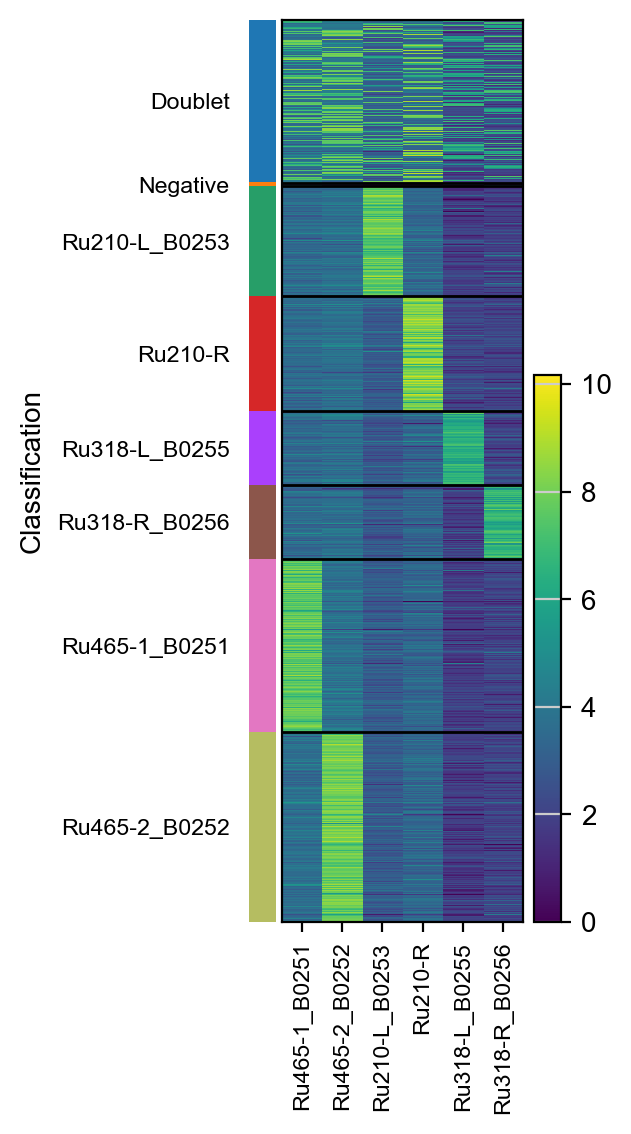

In [198]:
sc.pl.heatmap(adata,hashes,groupby="Classification",log=True)

In [199]:
from collections import Counter

Counter(adata.obs["Classification"])

Counter({'Doublet': 2599,
         'Ru210-L_B0253': 1758,
         'Ru465-1_B0251': 2765,
         'Ru210-R': 1834,
         'Ru465-2_B0252': 3028,
         'Ru318-L_B0255': 1179,
         'Ru318-R_B0256': 1178,
         'Negative': 60})

In [200]:
singlets = [x in hashes for x in adata.obs["Classification"] ]
adata = adata[singlets,]
adata

View of AnnData object with n_obs × n_vars = 11742 × 16381
    obs: 'Ru465-1_B0251', 'Ru465-2_B0252', 'Ru210-L_B0253', 'Ru210-R', 'Ru318-L_B0255', 'Ru318-R_B0256', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_human', 'pct_counts_human', 'total_counts_mt', 'pct_counts_mt', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'human', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt'
    uns: 'Classification_colors'

In [201]:
sc.pp.normalize_total(adata,target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [202]:
sc.pp.log1p(adata)

In [203]:
adatas.append(adata)

In [204]:
pdxFile = f"{inDir}{pdxName4}_filtered_feature_bc_matrix.h5"

# 4

In [205]:
adata = sc.read_10x_h5(pdxFile, gex_only=False)
adata

reading data/LUAD/PDX-JHU55A_Ru699_Ru890_filtered_feature_bc_matrix.h5
 (0:00:01)


/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


AnnData object with n_obs × n_vars = 11897 × 68891
    var: 'gene_ids', 'feature_types', 'genome'

In [206]:
numHash = adata.var["feature_types"].value_counts()["Antibody Capture"]

In [207]:
hto = adata[:,-numHash:]
adata = adata[:,:-numHash]

In [208]:
hashes = list(hto.var.index)

In [209]:
hashdf = pd.DataFrame(hto.X.todense(), index=adata.obs_names ,columns=hashes)

In [210]:
adata.obs = adata.obs.join(hashdf)

/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/anndata/_core/anndata.py:1832: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


In [211]:
adata.var_names_make_unique()
adata.obs_names_make_unique()

normalizing counts per cell
    finished (0:00:00)


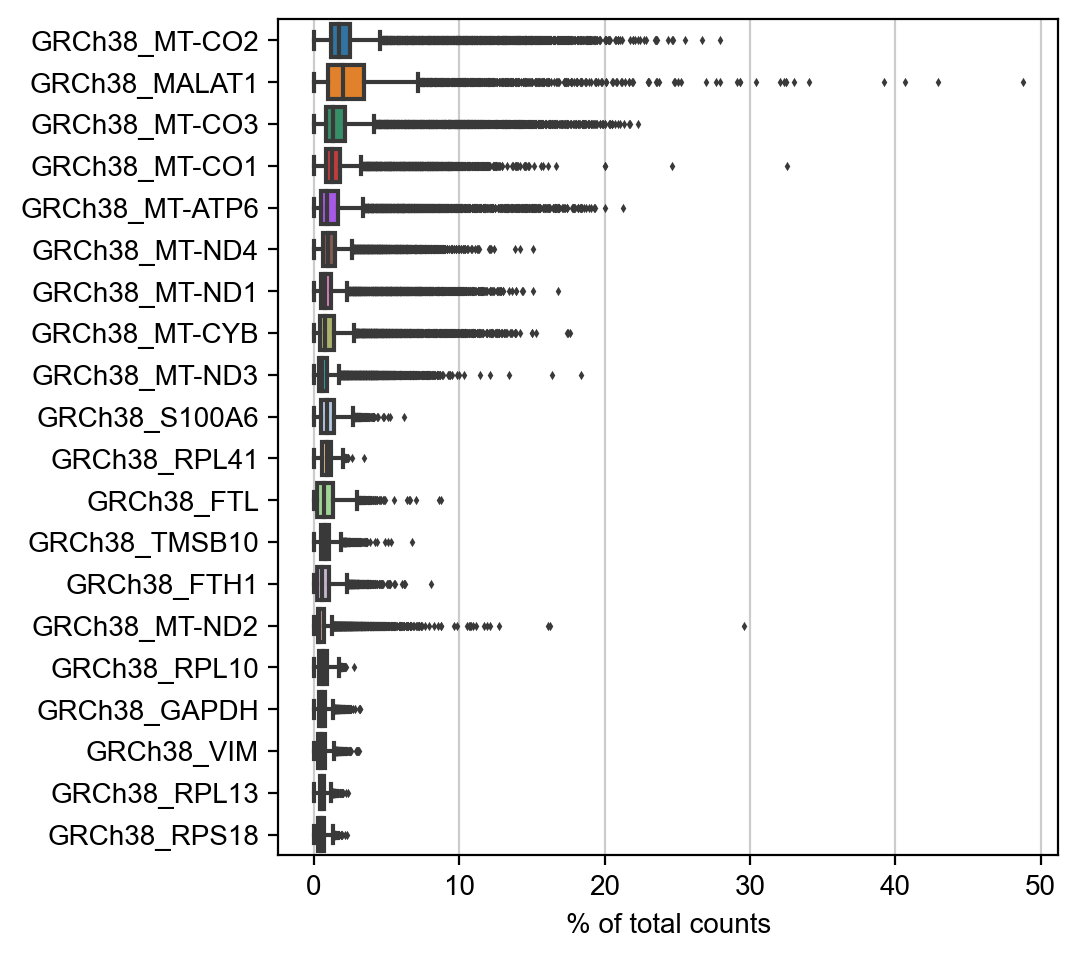

In [212]:
sc.pl.highest_expr_genes(adata, n_top=20, )

/var/folders/nc/t9t85q_94q7g4tf0gz83qts40000gn/T/ipykernel_15760/2123468045.py:22: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


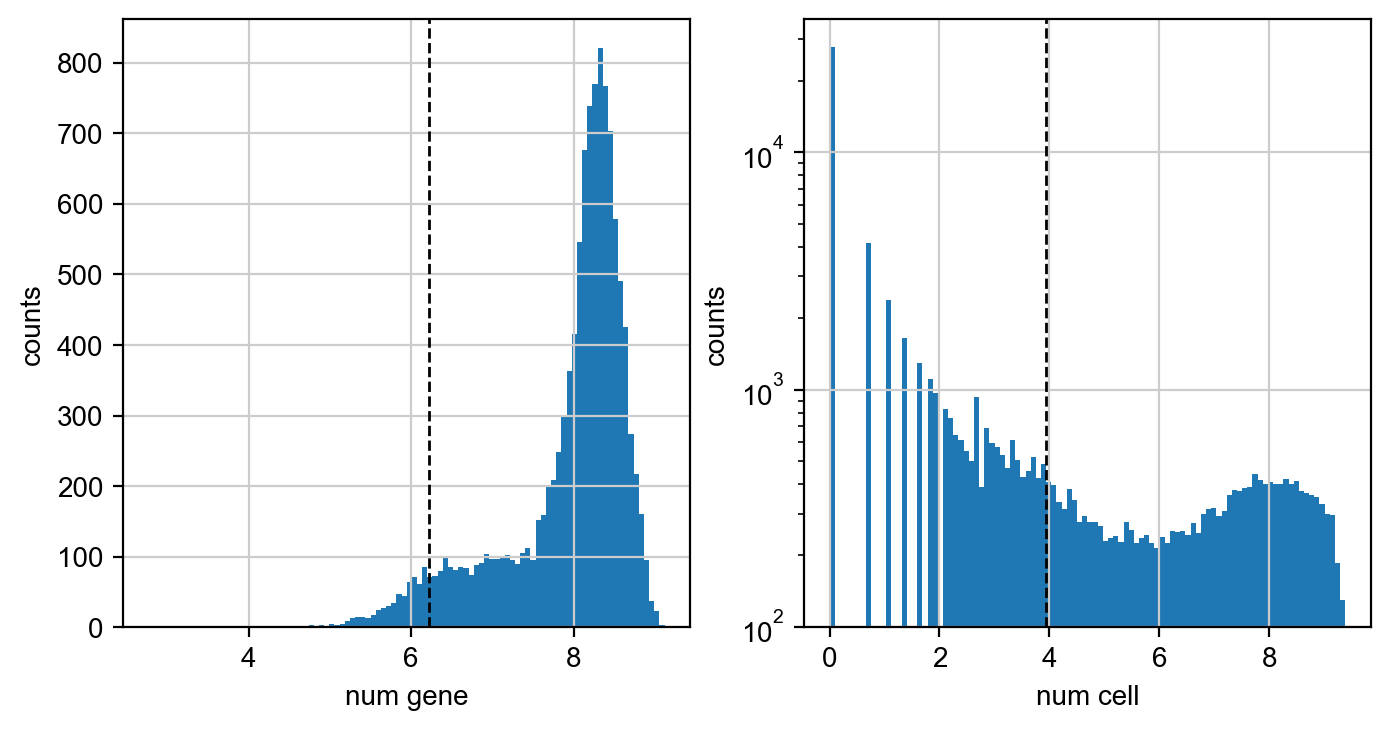

In [213]:
valX = adata.X>0
minGenes=500
minCells=50

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

numCellwExp = valX.sum(axis=1)
axs[0].hist(np.log(numCellwExp), bins=100)#, log=True)
axs[0].axvline(np.log(minGenes), color='k', linestyle='dashed', linewidth=1)
axs[0].set_xlabel('num gene')
axs[0].set_ylabel('counts')

numGeneswExp = valX.sum(axis=0).T
axs[1].hist(np.log(numGeneswExp+1), bins=100, log=True)
axs[1].axvline(np.log(minCells+1), color='k', linestyle='dashed', linewidth=1)
#axs[0,1].axvline(np.log(600), color='k', linestyle='dashed', linewidth=1)
#axs[0,1].axvline(np.log(4000), color='k', linestyle='dashed', linewidth=1)
#axs[0,1].set_title('Gene means counts')
axs[1].set_xlabel('num cell')
axs[1].set_ylabel('counts')

fig.show()

In [214]:
sc.pp.filter_cells(adata, min_genes = minGenes)
sc.pp.filter_genes(adata, min_cells = minCells)

filtered out 634 cells that have less than 500 genes expressed
filtered out 50913 genes that are detected in less than 50 cells


In [215]:
adata = adata[:,np.logical_not(adata.var_names=="GRCh38_MALAT1")]

In [216]:
adata.var['human'] = adata.var_names.str.startswith('GRCh38_') 
sc.pp.calculate_qc_metrics(adata, qc_vars=['human'], log1p = False, inplace=True)

/var/folders/nc/t9t85q_94q7g4tf0gz83qts40000gn/T/ipykernel_15760/989609383.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['human'] = adata.var_names.str.startswith('GRCh38_')


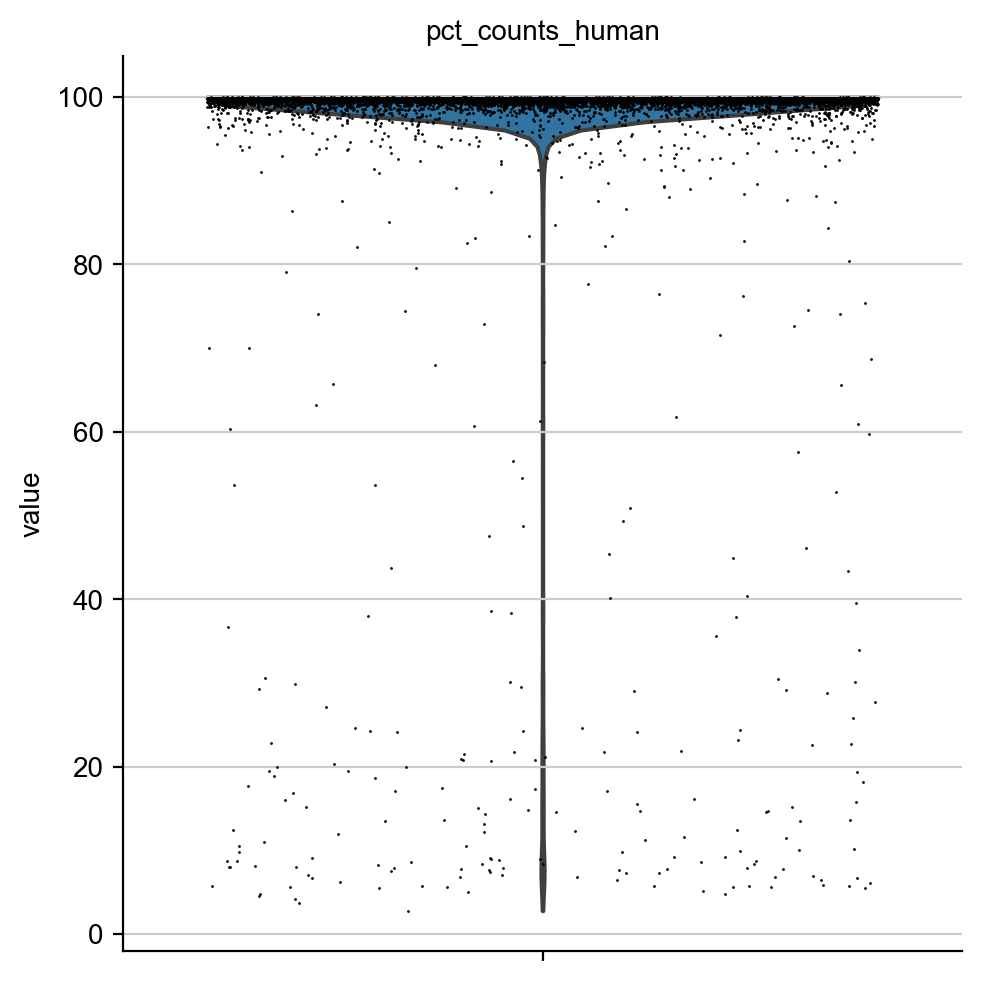

In [217]:
sc.pl.violin(adata, ['pct_counts_human'], jitter=0.4, multi_panel=True)

In [218]:
adata = adata[adata.obs.pct_counts_human > 99, :]

In [219]:
humanGenes = ['GRCh38_' in g for g in adata.var_names]
adata = adata[:,humanGenes]
humanGenes = [g.split("_")[1] for g in adata.var_names]
adata.var_names = humanGenes

In [220]:
adata.var_names

Index(['AL627309.5', 'LINC01409', 'FAM87B', 'LINC01128', 'LINC00115', 'FAM41C',
       'AL645608.2', 'SAMD11', 'NOC2L', 'KLHL17',
       ...
       'MT-ND6', 'MT-CYB', 'BX004987.1', 'MAFIP', 'AC011043.1', 'AL354822.1',
       'AL592183.1', 'AC240274.1', 'AC004556.3', 'AC007325.4'],
      dtype='object', length=16445)

In [221]:
adata.var['mt'] = adata.var_names.str.startswith('MT-') 
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], log1p = False, inplace=True)

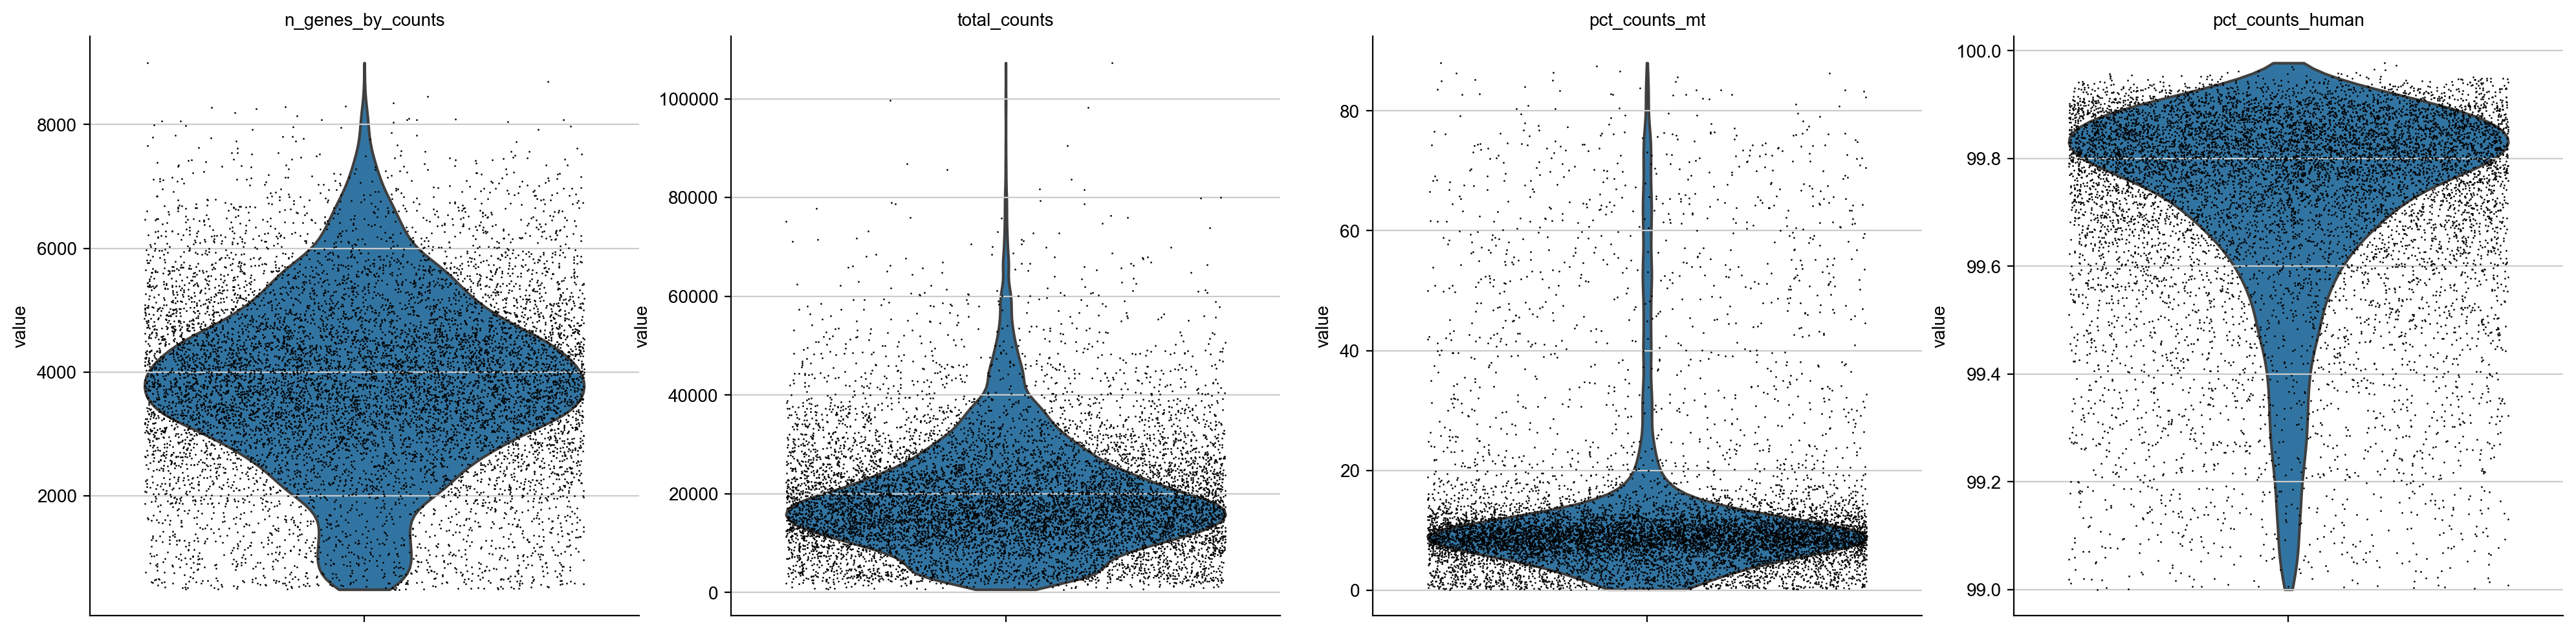

In [222]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_human'], jitter=0.4, multi_panel=True)

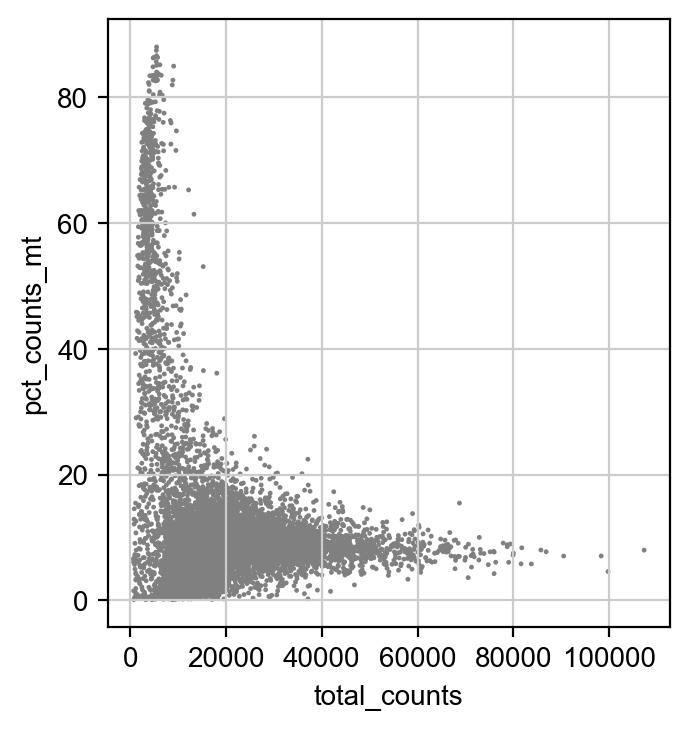

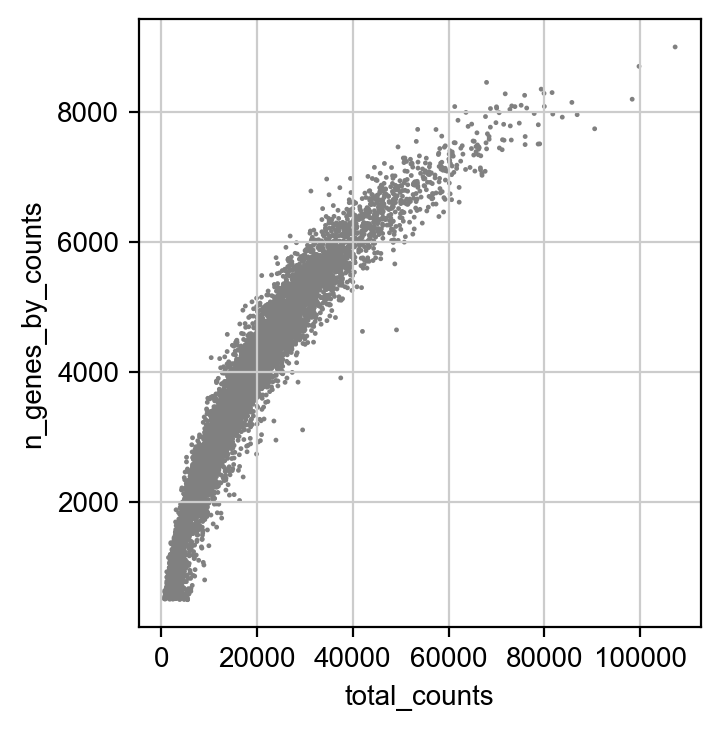

In [223]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')

In [224]:
adata = adata[adata.obs.n_genes_by_counts < 7000, :]
adata = adata[adata.obs.total_counts < 40000, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]

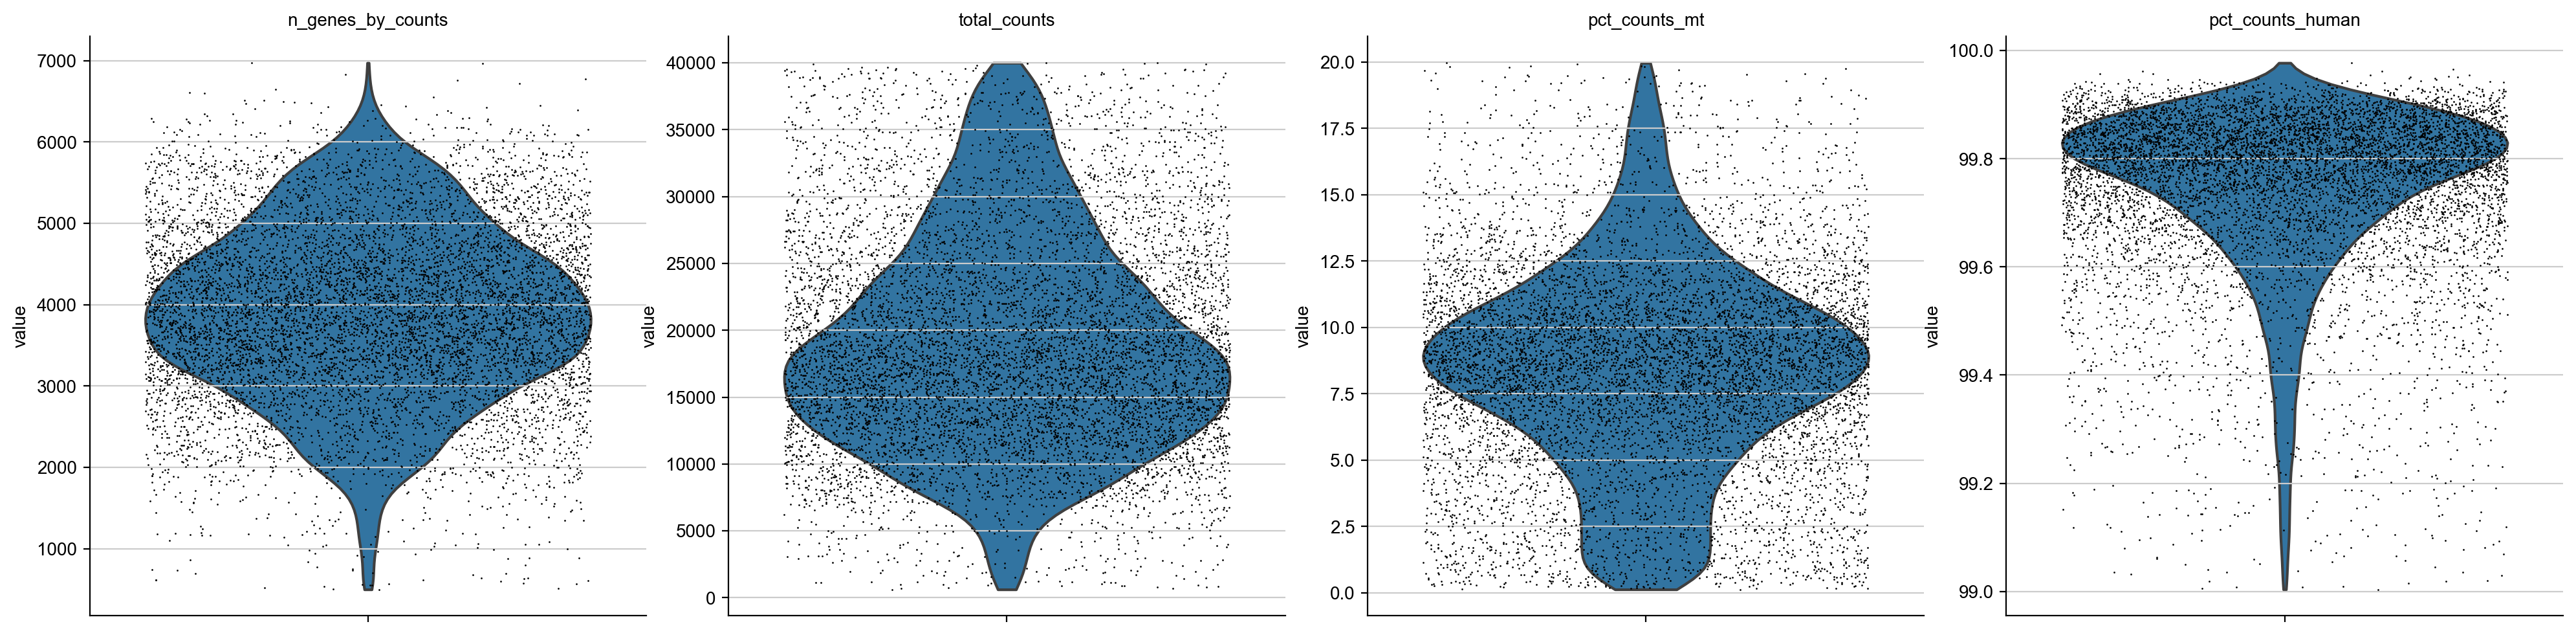

In [225]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt','pct_counts_human'], jitter=0.4, multi_panel=True)

In [226]:
adata

View of AnnData object with n_obs × n_vars = 8346 × 16445
    obs: 'JHU55A_B0251', 'JHU55A_B_B0252', 'Ru699_A_B0253', 'Ru699_B_B0254', 'Ru890_B0255', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_human', 'pct_counts_human', 'total_counts_mt', 'pct_counts_mt'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'human', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt'

In [227]:
hashes

['JHU55A_B0251',
 'JHU55A_B_B0252',
 'Ru699_A_B0253',
 'Ru699_B_B0254',
 'Ru890_B0255']

In [228]:
import scanpy.external as sce
sce.pp.hashsolo(adata, hashes)
adata.obs.head()

Please cite HashSolo paper:
https://www.cell.com/cell-systems/fulltext/S2405-4712(20)30195-2


/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/external/pp/_hashsolo.py:379: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata.obs["most_likely_hypothesis"] = results.loc[


JHU55A_B0251  JHU55A_B_B0252  Ru699_A_B0253  \
AAACCCAAGAAGCCTG-1        1784.0           867.0           44.0   
AAACCCAAGACATATG-1          60.0          2974.0           64.0   
AAACCCAAGGAGAATG-1        1895.0            55.0           55.0   
AAACCCAAGTGGGAAA-1         943.0             9.0           15.0   
AAACCCACACACTGGC-1        2831.0           100.0           77.0   

                    Ru699_B_B0254  Ru890_B0255  n_genes  n_genes_by_counts  \
AAACCCAAGAAGCCTG-1          354.0         10.0     3488               3468   
AAACCCAAGACATATG-1          373.0         12.0     4420               4398   
AAACCCAAGGAGAATG-1          320.0         25.0     4434               4418   
AAACCCAAGTGGGAAA-1          110.0       1165.0     4407               4393   
AAACCCACACACTGGC-1          391.0         10.0     4428               4400   

                    total_counts  pct_counts_in_top_50_genes  \
AAACCCAAGAAGCCTG-1       15732.0                   37.611238   
AAACCCAAGACATATG-1       22829.0                   31.937448   
AAACCCAAGGAGAATG-1       24242.0                   31.292798   
AAACCCAAGTGGGAAA-1       16634.0                   26.006974   
AAACCCACACACTGGC-1       22225.0                   34.132733   

                    pct_counts_in_top_100_genes  ...  total_counts_human  \
AAACCCAAGAAGCCTG-1                    50.629291  ...             15732.0   
AAACCCAAGACATATG-1                    44.369004  ...             22829.0   
AAACCCAAGGAGAATG-1                    42.706872  ...             24242.0   
AAACCCAAGTGGGAAA-1                    36.136828  ...             16634.0   
AAACCCACACACTGGC-1                    46.893138  ...             22225.0   

                    pct_counts_human  total_counts_mt  pct_counts_mt  \
AAACCCAAGAAGCCTG-1         99.727417           1669.0      10.608951   
AAACCCAAGACATATG-1         99.716087           1387.0       6.075606   
AAACCCAAGGAGAATG-1         99.876396           2572.0      10.609686   
AAACCCAAGTGGGAAA-1         99.927910           1118.0       6.721173   
AAACCCACACACTGGC-1         99.860710           1812.0       8.152981   

                    most_likely_hypothesis  cluster_feature  \
AAACCCAAGAAGCCTG-1                       2                0   
AAACCCAAGACATATG-1                       1                0   
AAACCCAAGGAGAATG-1                       1                0   
AAACCCAAGTGGGAAA-1                       2                0   
AAACCCACACACTGGC-1                       1                0   

                    negative_hypothesis_probability  \
AAACCCAAGAAGCCTG-1                     5.876173e-13   
AAACCCAAGACATATG-1                     8.959906e-06   
AAACCCAAGGAGAATG-1                     9.469215e-05   
AAACCCAAGTGGGAAA-1                     1.838579e-12   
AAACCCACACACTGGC-1                     1.039000e-05   

                    singlet_hypothesis_probability  \
AAACCCAAGAAGCCTG-1                        0.000293   
AAACCCAAGACATATG-1                        0.963063   
AAACCCAAGGAGAATG-1                        0.970177   
AAACCCAAGTGGGAAA-1                        0.000062   
AAACCCACACACTGGC-1                        0.960104   

                    doublet_hypothesis_probability  Classification  
AAACCCAAGAAGCCTG-1                        0.999707         Doublet  
AAACCCAAGACATATG-1                        0.036928  JHU55A_B_B0252  
AAACCCAAGGAGAATG-1                        0.029728    JHU55A_B0251  
AAACCCAAGTGGGAAA-1                        0.999938         Doublet  
AAACCCACACACTGGC-1                        0.039885    JHU55A_B0251  

[5 rows x 22 columns]

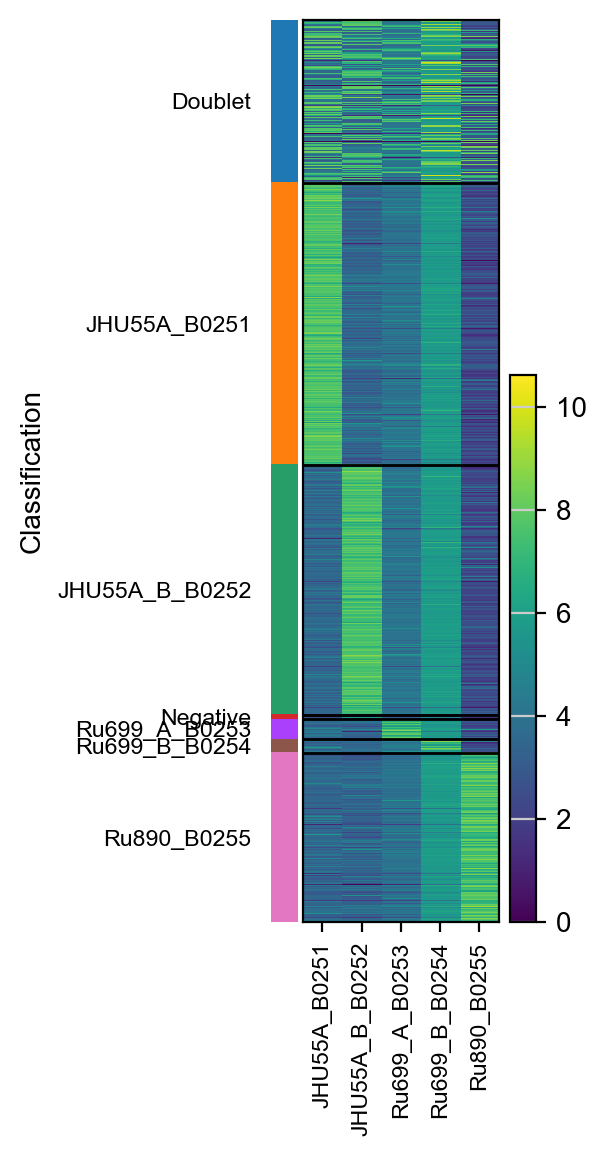

In [229]:
sc.pl.heatmap(adata,hashes,groupby="Classification",log=True)

In [230]:
from collections import Counter

Counter(adata.obs["Classification"])

Counter({'Doublet': 1506,
         'JHU55A_B_B0252': 2314,
         'JHU55A_B0251': 2607,
         'Ru890_B0255': 1568,
         'Negative': 42,
         'Ru699_A_B0253': 184,
         'Ru699_B_B0254': 125})

In [231]:
singlets = [x in hashes for x in adata.obs["Classification"] ]
adata = adata[singlets,]
adata

View of AnnData object with n_obs × n_vars = 6798 × 16445
    obs: 'JHU55A_B0251', 'JHU55A_B_B0252', 'Ru699_A_B0253', 'Ru699_B_B0254', 'Ru890_B0255', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_human', 'pct_counts_human', 'total_counts_mt', 'pct_counts_mt', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'human', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt'
    uns: 'Classification_colors'

In [232]:
sc.pp.normalize_total(adata,target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:170: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [233]:
sc.pp.log1p(adata)

In [234]:
adatas.append(adata)

In [235]:
adatas

[AnnData object with n_obs × n_vars = 8583 × 16373
     obs: 'LX369-1_B0251', 'LX369-2_B0252', 'Ru699_B0253', 'LX29_B0254', 'LX278-1_B0255', 'LX278-2_B0256', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_human', 'pct_counts_human', 'total_counts_mt', 'pct_counts_mt', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification'
     var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'human', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'mt'
     uns: 'Classification_colors', 'log1p',
 AnnData object with n_obs × n_vars = 5364 × 18594
     obs: 'LX55A_B0251', 'LX29A_B0252', 'LX369_B0253', 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top

In [236]:
#normalized pre-integration (done)

In [241]:
adata = sc.concat(adatas, label="PDX", keys=[pdxName1,pdxName2,pdxName3,pdxName4])
adata.obs_names_make_unique()

/Users/jonathanrub/miniforge3/envs/scDL/lib/python3.8/site-packages/anndata/_core/anndata.py:1830: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [242]:
adata

AnnData object with n_obs × n_vars = 32487 × 14481
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_human', 'pct_counts_human', 'total_counts_mt', 'pct_counts_mt', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'PDX'

In [243]:
resultsFileQC

'write/LUADpdx_QC.h5ad'

In [244]:
adata.write(resultsFileQC)

In [245]:
sc.read(resultsFileQC)

AnnData object with n_obs × n_vars = 32487 × 14481
    obs: 'n_genes', 'n_genes_by_counts', 'total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_human', 'pct_counts_human', 'total_counts_mt', 'pct_counts_mt', 'most_likely_hypothesis', 'cluster_feature', 'negative_hypothesis_probability', 'singlet_hypothesis_probability', 'doublet_hypothesis_probability', 'Classification', 'PDX'